# **Note Book d'exploration, de traitement et d'entrainement d'un model de machine learning pour la classification des logs d'un firewall**

## **1.   Introduction**

les firewall jouent un rôle crucial dans la sécurité des réseaux informatiques, ils fonctionnent notament grâce à des règles leur permettant d'effectuer une action en fonction des bytes, packets et meta données relatves à ces derniers qu'ils recoivent. L'analyse manuelle des logs d'un firewall pour affiner ces règles étant difficile il est alors judicieux d'utiliser un model de machine learning pour la prise d'action.
## **2.   Exploration des données**

### **2.1 Définiton de l'environnement d'execution**
ce notebook est confguré pour être mise à jour depuis mon repo github, étant donné que nous travaillons sur colab, j'effectue des configuration nécessaire pour que mon notebook fonctionne aussi bien en local que sur colab

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
import warnings
warnings.filterwarnings("ignore")

try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
if IN_COLAB:
    drive.mount('/content/drive')
    # Chemins dans Google Drive (adaptez selon votre structure)
    drive_path = "/content/drive/MyDrive/colab_shared/firewall_ml"
    data_dir = os.path.join(drive_path, "data")  # Chemin vers le dossier data
    notebooks_dir = os.path.join(drive_path, "notebooks")  # Chemin vers notebooks

    # Création des liens symboliques dans l'environnement Colab
    #os.symlink(data_dir, "/content/data")
    #os.symlink(notebooks_dir, "/content/notebooks")

    # Vérification
    print("Contenu de /content/data :", os.listdir(data_dir))
    print("Contenu de /content/notebooks :", os.listdir(notebooks_dir))
    sys.path.append(notebooks_dir)
    data_path = data_dir + "/external/firewall.csv"
else:
    data_path = '../data/external/firewall.csv'

In [3]:
# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### **2.2 DataSet**
Le dataSet est un csv issue de logs de pare feu de Fatih Ertam at Firat University. Il possède 12 features: [explication de chaque feature]

In [4]:
# Load the data
data = pd.read_csv(data_path)
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [6]:
data.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [7]:
data.describe(include=["O"])

,Action
count,65532
unique,4
top,allow
freq,37640


In [8]:
print("\nMissing Values Count by Column:")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values Count by Column:
Series([], dtype: int64)



Visualizing Missing Values...


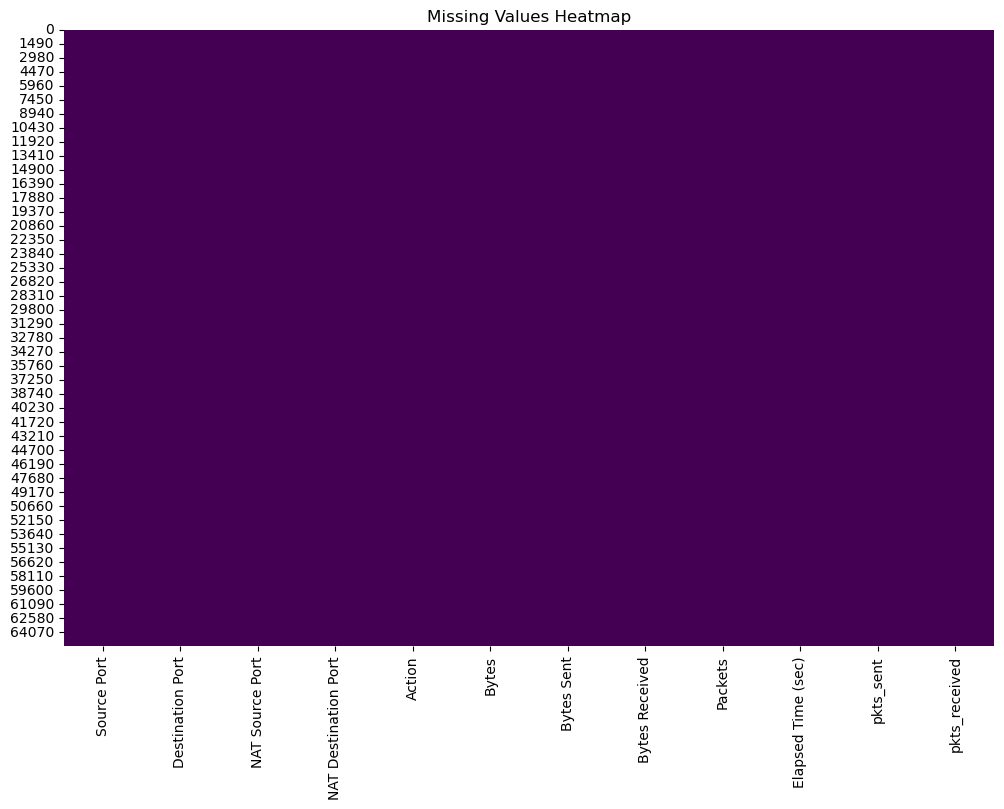

In [8]:
print("\nVisualizing Missing Values...")
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

on contate que le dataset n'a pas de ligne possèdans des valeurs null

In [9]:
port_features = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']
for port in port_features:
    data[port] = data[port].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  object
 1   Destination Port      65532 non-null  object
 2   NAT Source Port       65532 non-null  object
 3   NAT Destination Port  65532 non-null  object
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 6.0+ MB


Les ports ne seront pas considéré comme des valeurs numériques dans notre exploration

### **2.3 Analayses univarié**
### **2.3.1 Analyse de la variable cible "Action"**

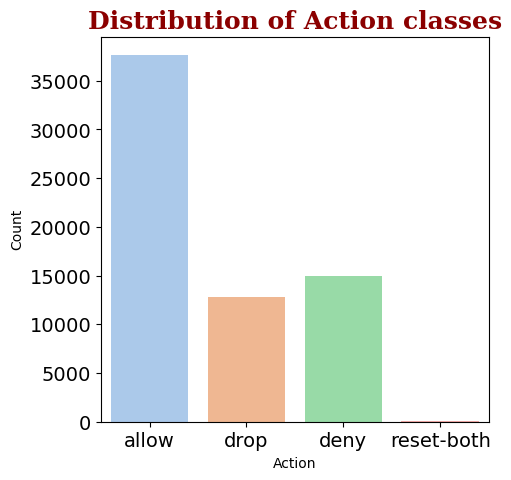

In [11]:
fig = plt.figure(figsize = (5, 5))
ax = sns.countplot(x = "Action", data = data, palette = 'pastel')
plt.title("Distribution of Action classes", fontdict = title_font)
plt.xlabel("Action")
plt.ylabel("Count")
# Set the tick labels font referred from (https://stackoverflow.com/a/23572192)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

Le graphique montre que l'ensemble de données contient quatre classes de variables de réponse, réparties de manière déséquilibrée. L'action « autoriser » est la plus fréquente, tandis que « réinitialiser les deux » est rare. Ceci est prévisible, car le trafic est autorisé la plupart du temps et, occasionnellement, « réinitialiser les deux », qui réinitialise les réseaux client-serveur, est nécessaire.

### **2.3.2 Analyse de la variable "Bytes"**

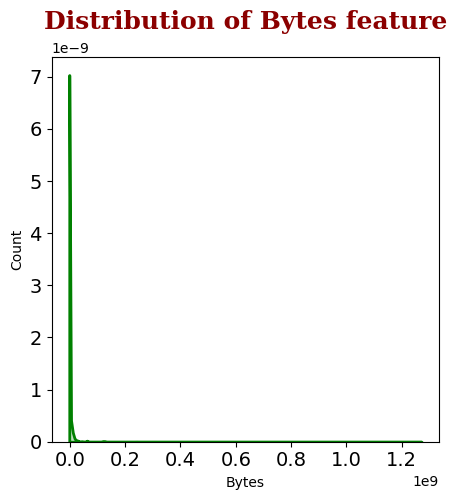

In [12]:
plt.figure(figsize = (5, 5))
ax = sns.distplot(data['Bytes'].values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green")
plt.title("Distribution of Bytes feature", fontdict = title_font, pad = 20.0)
plt.xlabel("Bytes")
plt.ylabel("Count")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

Le graphique montre que la fonction Bytes est extrêmement asymétrique à droite. Cela peut être dû à la présence de valeurs aberrantes. Voyons d'abord si elle peut être transformée en distribution gaussienne par transformation logarithmique ou par transformation Box-Cox.

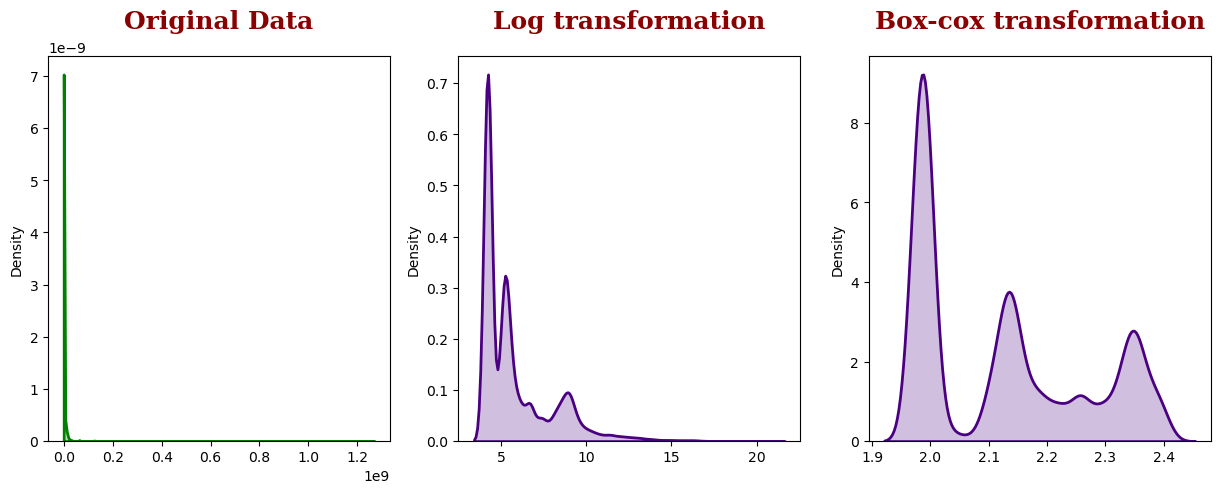

In [13]:
from scipy import stats
original_data = data['Bytes'].values

# applying log tranbsformation
log_data = np.log(original_data)
# applying Box-cox transformation
box_cox_data, lambda_ = stats.boxcox(original_data)

# creating axes to draw plots
fig, ax = plt.subplots(1, 3)

# plotting the distributions
sns.distplot(original_data, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green", ax = ax[0])
sns.distplot(log_data, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "indigo", ax = ax[1])
sns.distplot(box_cox_data, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "indigo", ax = ax[2])

# adding titles to the subplots
ax[0].set_title("Original Data", fontdict = title_font, pad = 20.0)
ax[1].set_title("Log transformation", fontdict = title_font, pad = 20.0)
ax[2].set_title("Box-cox transformation", fontdict = title_font, pad = 20.0)

# rescaling the figure
fig.set_figheight(5)
fig.set_figwidth(15)

Le graphique montre que la fonction Bytes présente une distribution multimodale et ne peut donc pas être transformée en distribution normale. Elle présente également des valeurs aberrantes et nécessite donc une étude plus approfondie. Les valeurs du 90e au 100e percentile peuvent nous donner une meilleure idée des valeurs aberrantes.

In [14]:
for i in range(90, 101):
    print(f"{i}th percentile value of Bytes feature is {int(np.percentile(data['Bytes'], i))}")

90th percentile value of Bytes feature is 8007
91th percentile value of Bytes feature is 8820
92th percentile value of Bytes feature is 9841
93th percentile value of Bytes feature is 11485
94th percentile value of Bytes feature is 14558
95th percentile value of Bytes feature is 20411
96th percentile value of Bytes feature is 32218
97th percentile value of Bytes feature is 64387
98th percentile value of Bytes feature is 152192
99th percentile value of Bytes feature is 520001
100th percentile value of Bytes feature is 1269359015


Nous observons que plus de 92 % des instances ont un nombre d'octets (Bytes) inférieur à 10 000, et que la valeur du 100e percentile entraîne une forte distorsion de la distribution de la variable Bytes. Nous pouvons également ignorer les valeurs de Bytes supérieures au 99e percentile. Néanmoins, la variable Bytes est extrêmement biaisée vers la droite. Vérifions la relation entre la variable Bytes et la variable de réponse Action. Pour des raisons d'interprétation, nous considérerons des valeurs inférieures à 10 000, car elles couvrent près de 93 % de l'ensemble de données.

In [12]:
# removing instances where Bytes are beyond 99th percentile
data = data[data['Bytes'] <= np.percentile(data['Bytes'], 99)]

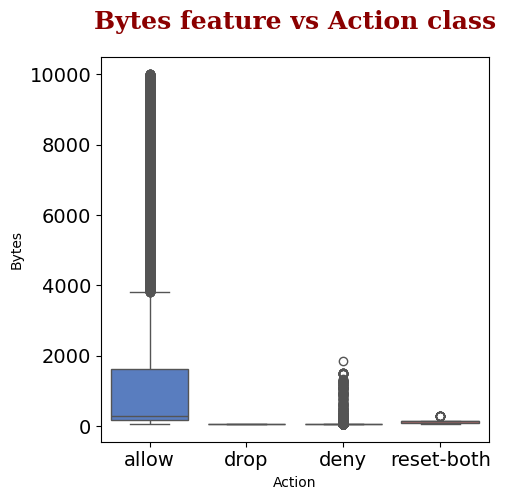

In [16]:
plt.figure(figsize = (5, 5))
ax = sns.boxplot(x = 'Action', y = 'Bytes', data = data[data['Bytes'] < 10000], palette = "muted")
plt.title("Bytes feature vs Action class", fontdict = title_font, pad = 20.0)
plt.xlabel("Action")
plt.ylabel("Bytes")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

Nous observons que plus le nombre d'octets est élevé, plus le trafic est susceptible d'être autorisé. Cependant, rien ne permet de prédire l'efficacité des trois autres classes d'actions en se basant uniquement sur la variable Bytes.

### **2.3.3 Analyse de la variable "Packets"**

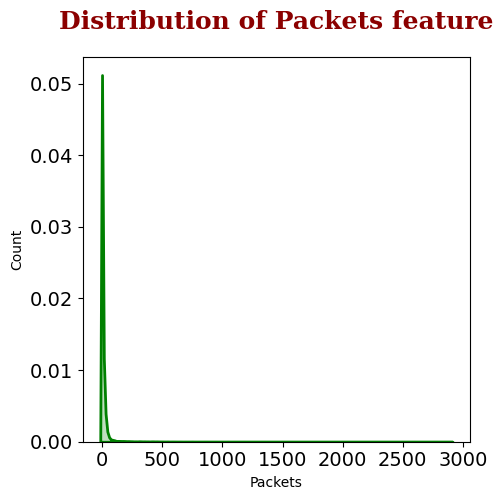

In [17]:
plt.figure(figsize = (5, 5))
ax = sns.distplot(data['Packets'].values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green")
plt.title("Distribution of Packets feature", fontdict = title_font, pad = 20.0)
plt.xlabel("Packets")
plt.ylabel("Count")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

Pareil qu'avec Bytes, on observe une grande asymétrie à droite, ce qui peut indiquer la présence de valeur abérrante. on va donc essayer d'effectuer comme précédement des transformation logarithmique ou Box-Cox dans le but de rendre la distribution gaussienne

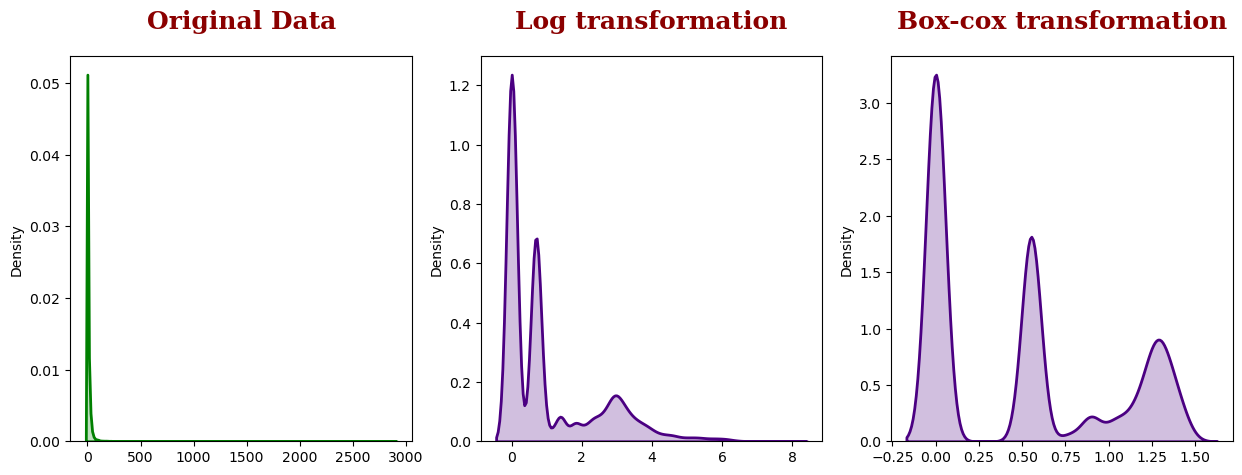

In [18]:
from scipy import stats
original_data = data['Packets'].values

# applying log tranbsformation
log_data = np.log(original_data)
# applying Box-cox transformation
box_cox_data, lambda_ = stats.boxcox(original_data)

# creating axes to draw plots
fig, ax = plt.subplots(1, 3)

# plotting the distributions
sns.distplot(original_data, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green", ax = ax[0])
sns.distplot(log_data, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "indigo", ax = ax[1])
sns.distplot(box_cox_data, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "indigo", ax = ax[2])

# adding titles to the subplots
ax[0].set_title("Original Data", fontdict = title_font, pad = 20.0)
ax[1].set_title("Log transformation", fontdict = title_font, pad = 20.0)
ax[2].set_title("Box-cox transformation", fontdict = title_font, pad = 20.0)

# rescaling the figure
fig.set_figheight(5)
fig.set_figwidth(15)

In [19]:
for i in range(90, 101):
    print(f"{i}th percentile value of Packets feature is {int(np.percentile(data['Packets'], i))}")

90th percentile value of Packets feature is 24
91th percentile value of Packets feature is 26
92th percentile value of Packets feature is 28
93th percentile value of Packets feature is 31
94th percentile value of Packets feature is 36
95th percentile value of Packets feature is 42
96th percentile value of Packets feature is 50
97th percentile value of Packets feature is 66
98th percentile value of Packets feature is 103
99th percentile value of Packets feature is 211
100th percentile value of Packets feature is 2897


même décision qu'avec la variable Bytes

In [13]:
# removing instances where Packets are beyond 99th percentile
data = data[data['Packets'] <= np.percentile(data['Packets'], 99)]

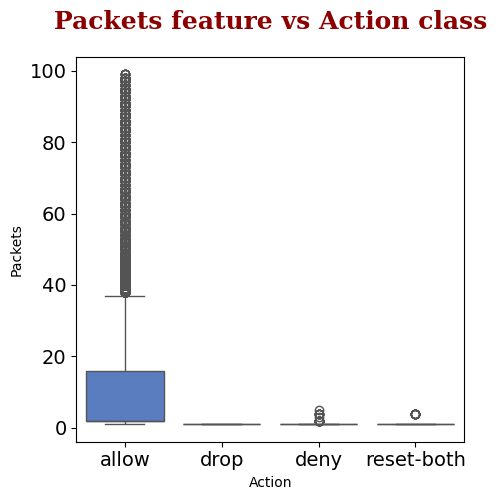

In [21]:
plt.figure(figsize = (5, 5))
ax = sns.boxplot(x = 'Action', y = 'Packets', data = data[data['Packets'] < 100], palette = "muted")
plt.title("Packets feature vs Action class", fontdict = title_font, pad = 20.0)
plt.xlabel("Action")
plt.ylabel("Packets")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

Encore une fois l'on ne peut pas dire grand chose sur les 3 autres classes de "Action" avec l'unique variable Packets

### **2.3.4 Analyse de la variable "Elapsed Time (sec)"**

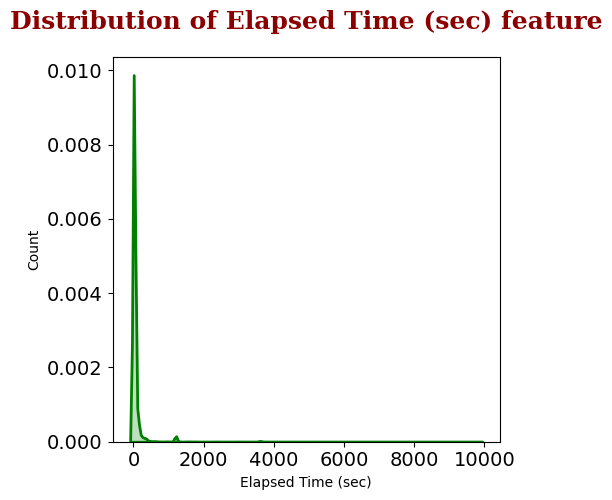

In [22]:
plt.figure(figsize = (5, 5))
ax = sns.distplot(data['Elapsed Time (sec)'].values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green")
plt.title("Distribution of Elapsed Time (sec) feature", fontdict = title_font, pad = 20.0)
plt.xlabel("Elapsed Time (sec)")
plt.ylabel("Count")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

In [23]:
for i in range(90, 101):
    print(f"{i}th percentile value of Elapsed Time (sec) feature is {int(np.percentile(data['Elapsed Time (sec)'], i))}")

90th percentile value of Elapsed Time (sec) feature is 89
91th percentile value of Elapsed Time (sec) feature is 118
92th percentile value of Elapsed Time (sec) feature is 121
93th percentile value of Elapsed Time (sec) feature is 134
94th percentile value of Elapsed Time (sec) feature is 143
95th percentile value of Elapsed Time (sec) feature is 179
96th percentile value of Elapsed Time (sec) feature is 251
97th percentile value of Elapsed Time (sec) feature is 324
98th percentile value of Elapsed Time (sec) feature is 710
99th percentile value of Elapsed Time (sec) feature is 1200
100th percentile value of Elapsed Time (sec) feature is 9851


In [14]:
# removing instances where Elapsed Time (sec) are beyond 99th percentile
data = data[data['Elapsed Time (sec)'] <= np.percentile(data['Elapsed Time (sec)'], 99)]

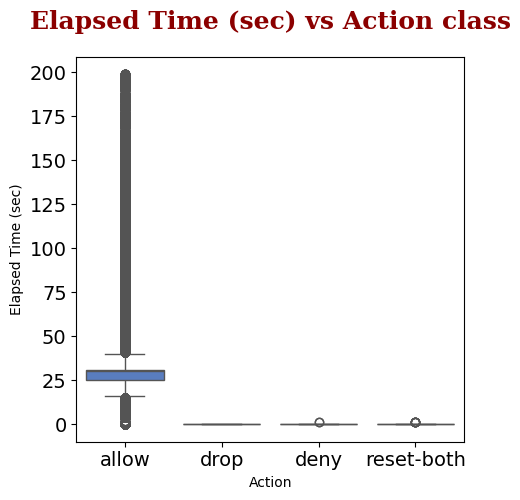

In [25]:
plt.figure(figsize = (5, 5))
ax = sns.boxplot(x = 'Action', y = 'Elapsed Time (sec)', data = data[data['Elapsed Time (sec)'] < 200], palette = "muted")
plt.title("Elapsed Time (sec) vs Action class", fontdict = title_font, pad = 20.0)
plt.xlabel("Action")
plt.ylabel("Elapsed Time (sec)")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

même observation qu'avec les variables "Bytes" et "Packets"

### **2.4 Analyse bivarié**

### **2.4.1 Matrice de correlation**



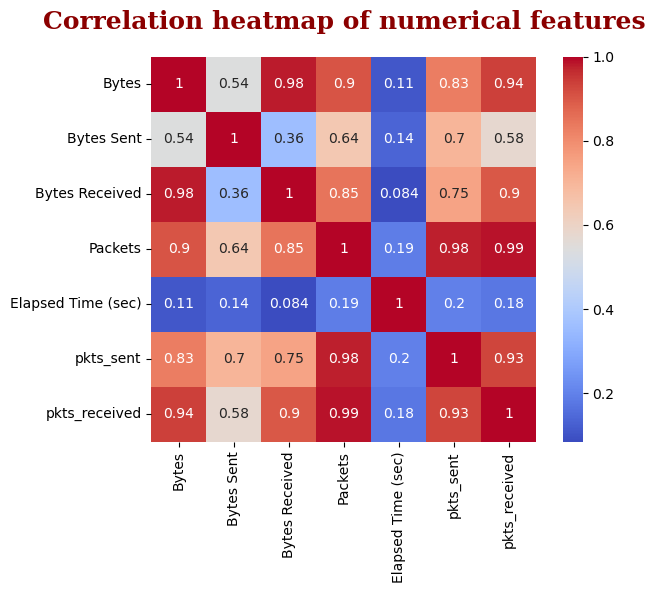

In [26]:
# selecting numerical features from the dataset
numerical = data.select_dtypes(include=['int64'])

# calculating correlation matrix
plt.figure(figsize=(7, 5))
correlation = numerical.corr()

# applying mask to crop the heatmap
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = False
ax = sns.heatmap(correlation, mask=mask, cmap="coolwarm", annot = True, square=True)

# formatting labels and title
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation = 90)
ax.set_yticklabels(ax.get_ymajorticklabels())
plt.title("Correlation heatmap of numerical features", fontdict = title_font, pad = 20.0)
plt.show()

Le graphique montre la corrélation entre les paires de variables numériques de l'ensemble de données. Comme on pouvait s'y attendre, les variables « Packets », « pkts_sent » et « pkts_received » sont fortement corrélées entre elles. De même, les variables « Bytes » et « Bytes Received » sont également fortement corrélées. En revanche, ce n'est pas le cas des variables « Bytes » et « Bytes Sent ». Cela peut être dû à une connectivité réseau incohérente. De plus, le temps écoulé (sec) n'est pas corrélé aux autres varibles, ce qui est évident car il ne s'agit pas d'une unité de communication de données comme les octets ou les paquets, qui sont également fortement corrélés.

<Figure size 1000x1000 with 0 Axes>

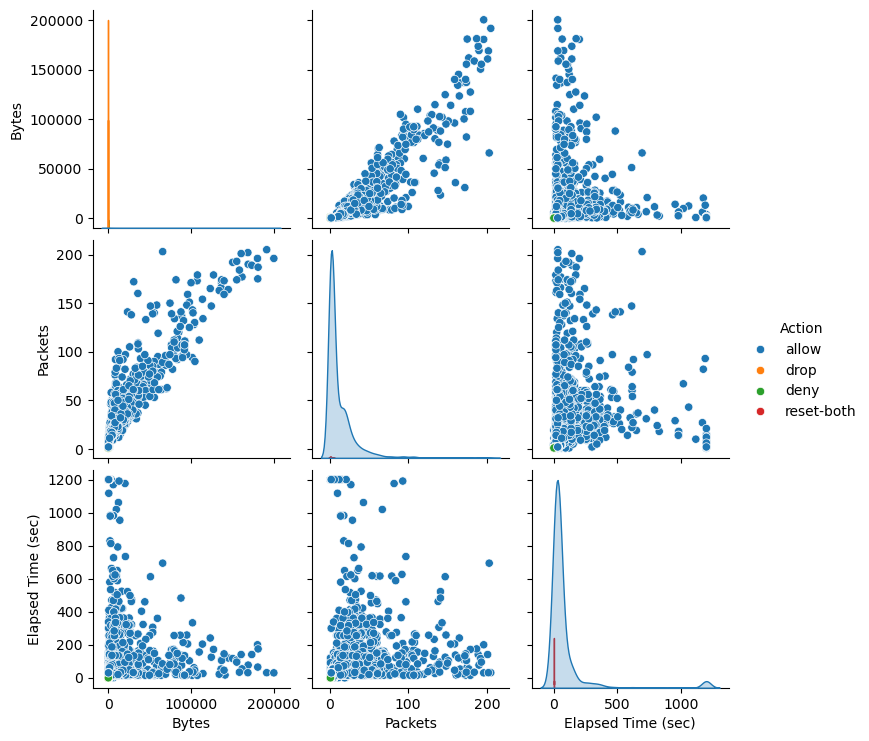

In [27]:
plt.figure(figsize = (10, 10))

# stratified sampling of 10000 points based on Action column referred from: (https://www.statology.org/stratified-sampling-pandas/)
sample_df = data[['Bytes', 'Packets', 'Elapsed Time (sec)', 'Action']]
N = 10000
sample_df = sample_df.groupby('Action', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(sample_df))))).sample(frac=1).reset_index(drop=True)

# plotting pairplot using random sample of 10000 datapoints to limit the file size
ax = sns.pairplot(data = sample_df, hue = 'Action')
plt.show()

Le graphique montre une forte relation linéaire entre les variables Bytes et Packets. L'action « Allow » domine le graphique en raison de la distribution aléatoire des variables. Cependant, on peut en déduire que des valeurs élevées de Bytes, de Packets et de Temps écoulé (sec) sont généralement associées au trafic autorisé. En revanche, rien ne peut être dit concernant les valeurs faibles de ces variables, car les classes se chevauchent. On observe aussi quelques cas particuliers qui entraine la suppression notament des Bytes nulls

 ### **2.5 Analyse multivarié**

 Nous allons maintenant visualiser toutes les caractéristiques numériques dans un espace bidimensionnel intégré à l'aide de T-sne. Cela nous donnera une meilleure idée de la séparabilité de la classe Action par caractéristiques numériques.

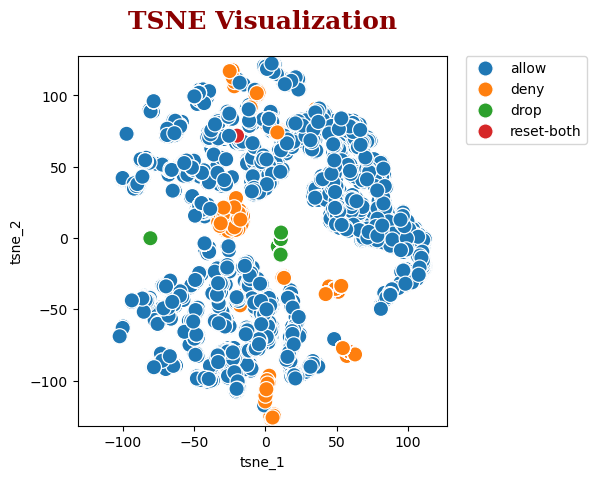

In [28]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# using sampled dataset of 10000 instances with all the numerical features to limit file size
sample_df = data[['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Action']]
N = 10000
sample_df = sample_df.groupby('Action', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(sample_df))))).sample(frac=1).reset_index(drop=True)
y = sample_df['Action']
X = sample_df.drop('Action', axis = 1)

# TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, random_state = 859)
tsne_result = tsne.fit_transform(X)

# plotting the result of TSNE with labels referred from (https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/)
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_title("TSNE Visualization", fontdict = title_font, pad = 20.0)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

Cette visualisation confirme les conclusions de l'analyse précédente. La classe d'action « allow » est séparable des trois autres classes d'action. Cependant, les variables numériques ne suffisent pas à elles seules à distinguer les classes d'action. Il est donc nécessaire d'utiliser des techniques de feature engineering pour améliorer la classification des caractéristiques des ports.

## **3 Feature Engineering**

Comme l'a montré l'analyse exploratoire des données, les caractéristiques numériques ne suffisent pas à elles seules à classer toutes les classes d'actions. Cependant, les informations sur les numéros de port impliqués dans le trafic peuvent nous aider à mieux classer les classes d'actions.

Commençons par comprendre les numéros de port dans l'ensemble de données. En réseau, les numéros de port désignent les numéros attribués à des services spécifiques, permettant d'identifier le service auquel chaque paquet est destiné. Au total, 65 535 ports sont disponibles pour effectuer une communication réseau.

Si le numéro de port indique le type de service demandé, il ne renseigne pas sur l'appareil hôte. L'appareil hôte est identifié par son adresse IP (Internet Protocol), qui est simplement l'adresse de cet appareil sur Internet. Il existe deux types d'adresses IP. L'adresse IP privée est l'adresse IP de l'appareil accédant à Internet, attribuée par le routeur, et l'adresse IP publique est fournie par le fournisseur d'accès à Internet (FAI) pour permettre la connexion. Les adresses IP sont définies par le protocole Internet version 4 (IPv4), une convention mondiale utilisant un numéro unique de 32 bits. Par conséquent, le nombre d'adresses uniques disponibles est toujours limité. Plus précisément, 232 adresses IP uniques sont disponibles.

Cependant, il est important de noter que les appareils non connectés à Internet, comme les machines d'usine qui communiquent uniquement entre elles via TCP/IP, n'ont pas besoin d'avoir d'adresses IP uniques au niveau mondial. Ces types de réseaux privés sont largement utilisés, et c'est le cas du réseau universitaire d'où vient le dataSet. Trois plages non chevauchantes de près de 18 millions d'adresses IP sont réservées à ces réseaux privés. Cela permet aux appareils connectés à l'environnement réseau partagé de se connecter à Internet avec la même adresse IP publique.

À cette fin, les routeurs ou le concentrateur réseau mettent en œuvre une technique appelée traduction d'adresses réseau (NAT). Fondamentalement, la NAT permet à un seul appareil, tel qu'un routeur, d'agir comme agent entre Internet (ou réseau public) et un réseau local (ou réseau privé). Autrement dit, une seule adresse IP unique suffit pour représenter un groupe d'ordinateurs vis-à-vis de tout ce qui se trouve en dehors de leur réseau (c'est-à-dire Internet). Si la NAT permet une meilleure utilisation de l'espace d'adressage IP, elle n'est pas toujours activée pour chaque communication au niveau du routeur. Cela signifie que les numéros de port peuvent parfois être utilisés sur Internet sans conversion.

### **3.1 Translation Port**
L'ensemble de données que nous utilisons contient des numéros de port enregistrés sur des appareils privés, ainsi que des numéros de port traduits par NAT. Nous pouvons ainsi créer deux entités pour la source et la destination, en fonction des informations indiquant si une traduction de port (NAT) est requise lors du transfert du trafic. Les entités « Source Port Translatiob » et « Destination Port Translation » peuvent être codées par 1 si les numéros de port des appareils et de NAT sont différents, indiquant la nécessité d'une NAT. Sinon, elles seront codées par 0, indiquant qu'aucune traduction n'est requise.

In [15]:
data['Source Port Translation'] = (data['Source Port'] != data['NAT Source Port']).astype('int')
data['Destination Port Translation'] = (data['Destination Port'] != data['NAT Destination Port']).astype('int')

In [16]:
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port Translation,Destination Port Translation
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,1,0
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,0,0
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,1,0
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,0,0
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,1,0


Nous pouvons également extraire davantage de fonctionnalités en construisant un réseau de ports source et de destination à l'aide de la bibliothèque networkx. L'importance d'un port particulier peut être implicite dans la détermination de l'action du trafic. La construction d'un réseau nous permet d'explorer ces fonctionnalités. Dans l'ensemble de données, nous avons des ports source et de destination côté des deux périphériques hôtes, ainsi que des NAT. Nous pouvons donc construire deux réseaux à partir de ces numéros de port.

In [17]:
import networkx as nx

# Fonction de remplacement pour nx.info()
def graph_info(G):
    print(f"Name: {G.name}")
    print(f"Type: {type(G)}")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    # Calcul des degrés moyens
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    avg_in_degree = sum(in_degrees.values()) / G.number_of_nodes()
    avg_out_degree = sum(out_degrees.values()) / G.number_of_nodes()

    print(f"Average in-degree: {avg_in_degree:.2f}")
    print(f"Average out-degree: {avg_out_degree:.2f}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Building bidirectional graph by using port numbers on host devices
HOST_NW = nx.DiGraph(name="Host")
HOST_NW.add_edges_from(data[['Source Port', 'Destination Port']].dropna().values)  # .dropna() ajouté pour gérer les NaN
print("Host Network:")
graph_info(HOST_NW)

print("-"*50)

# Building bidirectional graph by using port numbers on NAT
NAT_NW = nx.DiGraph(name="NAT")
NAT_NW.add_edges_from(data[['NAT Source Port', 'NAT Destination Port']].dropna().values)
print("NAT Network:")
graph_info(NAT_NW)

Host Network:
Name: Host
Type: <class 'networkx.classes.digraph.DiGraph'>
Number of nodes: 23931
Number of edges: 37463
Average in-degree: 1.57
Average out-degree: 1.57
Average degree: 3.13
--------------------------------------------------
NAT Network:
Name: NAT
Type: <class 'networkx.classes.digraph.DiGraph'>
Number of nodes: 28848
Number of edges: 32536
Average in-degree: 1.13
Average out-degree: 1.13
Average degree: 2.26


### **3.2 Common Port**
Le nombre de ports communs entre le port source et le port de destination peut être considéré comme une caractéristique. Des ports communs pour le périphérique hôte et la NAT peuvent être utilisés. Soit Γ(P) le nombre de ports connectés directement au port P, également appelé degré de P, et Ps et Pd les ports source et de destination respectivement. Les ports communs peuvent alors être calculés comme suit :
$$ CP(P_s, P_d) = | \Gamma(P_s) \cap \Gamma(P_d) |$$

In [18]:
def common_ports(nw, src, dst):
    """
    Counts no. of common ports connected directly between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        No. of common ports from intersection of set of neighbors of both src and dst ports
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst))))
    except:
        return 0

# adding features to the dataset
data['Host CP'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT CP'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

### **3.3 Jaccard Index**
L'indice Jaccard est calculé par le nombre de ports communs entre le port source et le port de destination divisé par le nombre total de ports connectés à chacun des ports source et de destination.
$$ JI(P_s, P_d) = \frac{ | \Gamma(P_s) \cap \Gamma(P_d) | }{| \Gamma(P_s) \cup \Gamma(P_d) |}$$


In [19]:
def jaccard_index(nw, src, dst):
    """
    Counts Jaccard index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Jaccard Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / len(set(nw.neighbors(src)).union(set(nw.neighbors(dst))))
    except:
        return 0

# adding features to the dataset
data['Host JI'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT JI'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

### **3.4 Salton Index**

L'indice de Salton, également appelé similarité cosinus, calcule le rapport entre le nombre de ports partagés entre les ports source et de destination et la racine carrée du produit de leurs degrés.

In [20]:
def salton_index(nw, src, dst):
    """
    Counts Salton index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Salton Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / np.sqrt(len(set(nw.neighbors(src))) * len(set(nw.neighbors(dst))))
    except:
        return 0

# adding features to the dataset
data['Host SL'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT SL'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

### **3.5 Sorensen Index**
L'indice de Sorensen est similaire à l'indice de Jaccard, sauf que le dénominateur est la somme nette contrairement à l'union.
$$ SI(P_s, P_d) = \frac{ | \Gamma(P_s) \cap \Gamma(P_d) | }{| \Gamma(P_s)| + |\Gamma(P_d) |}$$

In [21]:
def sorensen_index(nw, src, dst):
    """
    Counts Sorensen index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Sorensen Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / (len(set(nw.neighbors(src))) + len(set(nw.neighbors(dst))))
    except:
        return 0

# adding features to the dataset
data['Host SI'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT SI'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

### **3.6 Academic Acar Index**
L'index Adamic-Adar est spécialement conçu pour comparer deux pages web. Similaire aux ports courants, il pénalise les pages web rares en récupérant des journaux, qui, dans notre cas, pourraient être frauduleux.
$$ AA(P_s, P_d) = \sum_{P \in{\Gamma(P_s) \cap \Gamma(P_d)}}{\frac{1}{|\log(\Gamma(P))|}}$$

In [22]:
def adamic_adar_index(nw, src, dst):
    """
    Counts Adamic-Adar index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Adamic-Adar Index
    """
    try:
        ports = set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))
        return 1/np.sum([np.log10(set(nw.neighbors(port))) for port in ports])
    except:
        return 0

# adding features to the dataset
data['Host AA'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT AA'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

### **3.7 Page Rank**

PageRank calcule le classement des ports dans le graphe réseau G en fonction de la structure des liens entrants. Initialement conçu comme un algorithme de classement des pages web dans le moteur de recherche Google, il permet de calculer le classement des ports source et de destination des réseaux hôte et NAT.

In [23]:
# networkx library provides a function to calculate page rank of ports in the networks. It returns a dictionary where keys are ports and values are pageranks.
host_page_rank = nx.pagerank(HOST_NW)
nat_page_rank = nx.pagerank(NAT_NW)

# adding features to the dataset
data['Host Source PR'] = data.apply(lambda row: host_page_rank.get(row['Source Port'], 0), axis = 1)
data['Host Destination PR'] = data.apply(lambda row: host_page_rank.get(row['Destination Port'], 0), axis = 1)
data['NAT Source PR'] = data.apply(lambda row: nat_page_rank.get(row['NAT Source Port'], 0), axis = 1)
data['NAT Destination PR'] = data.apply(lambda row: nat_page_rank.get(row['NAT Destination Port'], 0), axis = 1)

## **4 Data Preprocessing**
### **4.1 Splitting the dataset in training and validation sets**
Nous disposons désormais de l'ensemble de données nécessaire à la construction des modèles de machine learning. Cependant, faute d'ensemble de test distinct, nous ne pouvons pas évaluer les performances de notre modèle. Par conséquent, nous allons diviser notre ensemble de données en un ensemble d'apprentissage et un ensemble de validation à l'aide de la technique d'échantillonnage stratifié afin de conserver la même distribution des classes d'actions dans les deux ensembles. Nous conserverons également un ensemble comme ensemble de test pour évaluer la perte logarithmique.

In [24]:
from sklearn.model_selection import train_test_split
y = data['Action']
X = data.drop(['Action'], axis = 1)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.10, stratify = y, random_state = 859)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, stratify = y_train, random_state = 859)
print(f"The shape of the training set: {X_train.shape}")
print(f"The shape of the validation set: {X_cv.shape}")
print(f"The shape of the test set: {X_test.shape}")

The shape of the training set: (45085, 27)
The shape of the validation set: (6262, 27)
The shape of the test set: (11272, 27)


### **4.2 Scaling the values**

Comme nous l'avons vu précédemment, les valeurs numériques du jeu de données ont des échelles très différentes. Il est donc nécessaire de mettre à l'échelle ces variables. RobustScaler, de la bibliothèque sklearn, est idéal pour mettre à l'échelle ces variables numériques, car il neutralise les effets des valeurs aberrantes dans le jeu de données. Pour les variables techniques, nous pouvons utiliser StandardScaler.

In [25]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# applying RobustScaler
robust_scaler = RobustScaler()
robust_scaler_features = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Host Source PR', 'Host Destination PR', 'NAT Source PR', 'NAT Destination PR']
X_train_robust_scaled = robust_scaler.fit_transform(X_train[robust_scaler_features])
X_cv_robust_scaled = robust_scaler.transform(X_cv[robust_scaler_features])
X_test_robust_scaled = robust_scaler.transform(X_test[robust_scaler_features])

# applying StandardScaler
std_scaler = StandardScaler()
std_scaler_features = ['Host CP', 'NAT CP', 'Host JI', 'NAT JI', 'Host SL', 'NAT SL', 'Host SI', 'NAT SI', 'Host AA', 'NAT AA']
X_train_std_scaled = std_scaler.fit_transform(X_train[std_scaler_features])
X_cv_std_scaled = std_scaler.transform(X_cv[std_scaler_features])
X_test_std_scaled = std_scaler.transform(X_test[std_scaler_features])

# stacking the scaled features
X_train_preprocessed = np.hstack((X_train[X_train.columns[:4]], X_train_robust_scaled, X_train_std_scaled, X_train[['Source Port Translation', 'Destination Port Translation']]))
X_cv_preprocessed = np.hstack((X_cv[X_cv.columns[:4]], X_cv_robust_scaled, X_cv_std_scaled, X_cv[['Source Port Translation', 'Destination Port Translation']]))
X_test_preprocessed = np.hstack((X_test[X_test.columns[:4]], X_test_robust_scaled, X_test_std_scaled, X_test[['Source Port Translation', 'Destination Port Translation']]))

# checking the dimensions of the datasets after preprocessing
print(f"The shape of the training set after preprocessing: {X_train_preprocessed.shape}")
print(f"The shape of the validation set after preprocessing: {X_cv_preprocessed.shape}")
print(f"The shape of the test set after preprocessing: {X_test_preprocessed.shape}")

The shape of the training set after preprocessing: (45085, 27)
The shape of the validation set after preprocessing: (6262, 27)
The shape of the test set after preprocessing: (11272, 27)


## **5 Data Modeling**
### **5.1 Choose the performance metric**

Pour évaluer les performances d'un modèle d'apprentissage automatique, le choix de la bonne métrique est crucial. La qualité d'un modèle dépend de sa performance. Cependant, la métrique elle-même ne garantit pas son bon fonctionnement en temps réel. Par conséquent, quelle que soit la tâche sous-jacente, la métrique doit être adaptée à son application en temps réel.

La tâche consiste ici à classer la classe Action des données du journal d'un pare-feu. Il s'agit d'une classification multiclasse, car la classe Action appartient à quatre classes distinctes. La répartition entre ces classes est également inégale, ce qui indique un déséquilibre dans l'ensemble de données. Par conséquent, la précision simple (Accuracy ou autre) ou l'AUC ne peuvent pas être utilisées, car elles ne prennent pas en compte le déséquilibre des classes. Il est également important de prédire correctement chaque classe. De plus, le modèle implémenté doit être capable de prédire la probabilité de la classe prédite pour l'interprétabilité, plutôt que de prédire directement les classes sous contrainte stricte.

Il nous reste donc la perte logarithmique multiclasse comme métrique. Généralement, même si elle est interprétée comme une mesure d'erreur par le modèle, elle peut servir de mesure d'évaluation, car la performance du modèle présentant une perte logarithmique plus faible est considérée comme meilleure. En effet, elle pénalise les prédictions peu fiables. Elle est définie comme suit :
$$ logloss = - \frac{1}{N} \sum_{i=1}^{N}{\sum_{j=1}^{M}{y_{ij}\log(p_{ij})}}$$
où : $N$ = taille des donnée;
$M$ = nombre de classe;
$y_{ij}$ =  label de la ie instance pour la jieme class;
$p_{ij}$ = probabilité pour la ie instance d'être de la je classe

In [26]:
def plot_confusion_matrix(truths, predictions, labels = data['Action'].unique()):
    """
    Plots the confusion matrix for all the classes in order to interpret the performance of the model.

    Args:
        truths: Actual labels of the instances
        predictions: predicted labels of the instances by the model

    Returns:
        None
    """
    print("\n")
    matrix = confusion_matrix(truths, predictions)
    # matrix = (4,4) matrix where each cell (i,j) represents number of points of class i which are predicted as of class j
    precision = matrix/np.sum(matrix, axis = 0)
    # precision = (4,4) matrix where each cell (i,j) represents it's precision i.e. TP/(TP+FP) which is value/column_sum in confusion matrix
    recall = (matrix.T/np.sum(matrix, axis = 1)).T
    # recall = (4,4) matrix where each cell (i,j) represents it's recall i.e. TP/(TP+FN) which is value/row_sum in confusion matrix

    # creating axes to draw plots
    fig, ax = plt.subplots(1, 3)
    cmap = sns.light_palette("purple")

    # plotting the matrices using heatmaps from seaborn library
    titles = [("Confusion matrix", matrix), ("Precision matrix", precision), ("Recall matrix", recall)]
    for i, j in enumerate(titles):
        if j[0] == "Confusion matrix":
            sns.heatmap(j[1], annot = True, cmap = cmap, fmt = "", xticklabels = labels, yticklabels = labels, ax = ax[i])
        else:
            sns.heatmap(j[1], annot = True, cmap = cmap, vmin = 0, vmax = 1, fmt = ".2f", xticklabels = labels, yticklabels = labels, ax = ax[i])
        ax[i].set_xticklabels(ax[i].get_xmajorticklabels())
        ax[i].set_yticklabels(ax[i].get_ymajorticklabels(), rotation = 0)
        ax[i].set_title(j[0], fontdict = title_font)
        ax[i].set_xlabel("Predicted labels")
        ax[i].set_ylabel("Original labels")

    # rescaling the figure
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.tight_layout()

### **5.2 Baseline Model**
La mesure de performance que nous avons choisie (la perte logarithmique multiclasse) n'est pas interprétable seule, car il s'agit simplement d'un nombre. Par conséquent, pour évaluer notre modèle, nous devons obtenir une idée de la perte logarithmique d'un modèle de référence aléatoire. La variable Action de notre ensemble de données étant distribuée de manière inégale, nous pouvons construire un modèle aléatoire qui prédit la classe Action en générant une probabilité aléatoire pour chaque classe Action proportionnelle à son poids dans l'ensemble de données.

In [27]:
def baseline_model(feature_matrix, train_labels):
    """
    Generates random probabilities of output class proportional to their weights, where weights are no.of instances of that class divided by total no.
    of instances in the train data

    Args:
        feature_matrix: Feature matrix of the dataset
        train_labels: Actual labels of the instances in the train data

    Returns:
        random class labels as predictions
    """
    classes = list(train_labels.unique())
    # classes = no.of unique classes
    class_weights = [np.sum(train_labels == i)/train_labels.shape[0] for i in train_labels.unique()]
    # class_weights = list of class weights computed from train data
    labels = np.random.choice(classes, size = feature_matrix.shape[0], p = class_weights)
    # labels = predicted labels by random sampling of class labels proportional to their weights in train data
    probs = np.zeros((labels.shape[0], len(classes)))
    # probs = matrix of predicted probabilities
    for i in range(labels.shape[0]):
        # generate probabilities by adding random numbers between 0 and 1 to predicted class labels which ensures it has highest probability among all classes
        probs[i] = classes.index(labels[i]) + np.random.random_sample(len(classes))
        # normalizing probabilities of all classes so that they add up to 1
        probs[i] /= np.sum(probs[i])
    # probs = normalized random probabilities of output classes
    return labels, probs

Nous pouvons maintenant vérifier les performances du modèle de référence en calculant la perte logarithmique sur les données de test. Nous pouvons également visualiser les performances du modèle de référence en traçant les matrices de confusion, de précision et de rappel.

Log loss on Train Data using Random Model: 1.5424784999460697
Log loss on Test Data using Random Model: 1.5214143823398578




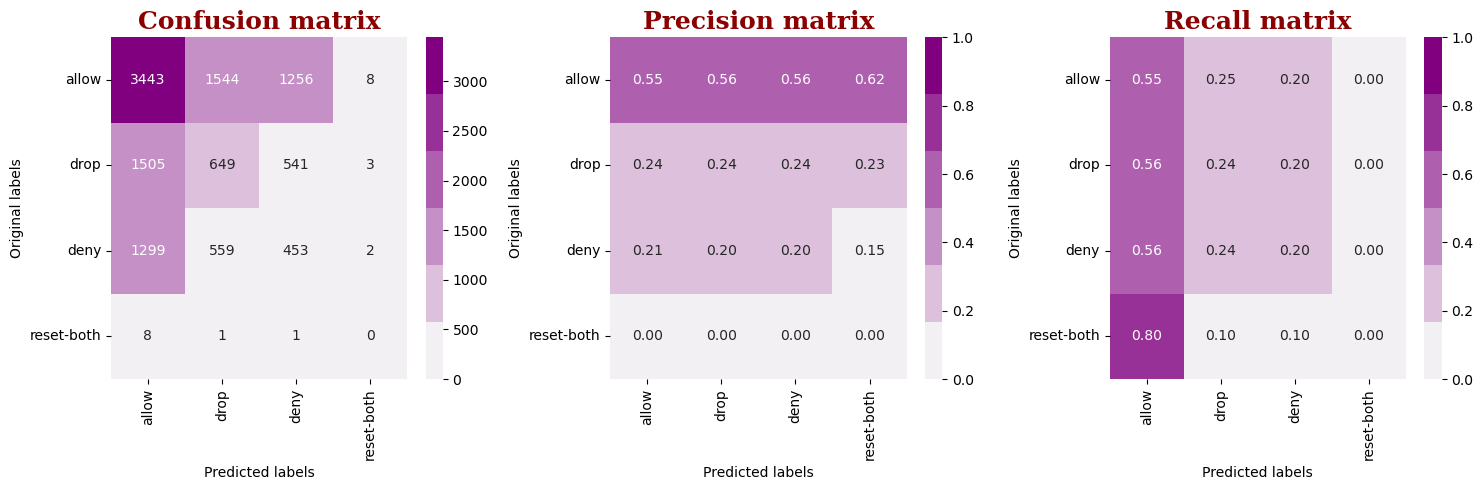

In [37]:
from sklearn.metrics import log_loss, confusion_matrix
random_model_train_labels, random_model_train_probs = baseline_model(X_train, y_train)
random_model_test_labels, random_model_test_probs = baseline_model(X_test, y_train)

random_model_train_loss = log_loss(y_train, random_model_train_probs)
print(f"Log loss on Train Data using Random Model: {random_model_train_loss}")
random_model_test_loss = log_loss(y_test, random_model_test_probs)
print(f"Log loss on Test Data using Random Model: {random_model_test_loss}")
plot_confusion_matrix(y_test, random_model_test_labels)

Le modèle de référence présente une perte logarithmique de 1,45. Par conséquent, pour pouvoir exploiter notre modèle, nous devons obtenir une perte logarithmique bien inférieure à 1,45.

### **5.3 KNN CLassifier**
Nous utiliserons ici et pour les autres modèles la technique de réglage des hyperparamètres RandomizedSearchCV pour obtenir la meilleur valeur des hyperparamètres.

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

# tuning the hyperparameters on training data
knn_parameters = {'n_neighbors': [5, 8, 10, 15, 20], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
random_search_knn = RandomizedSearchCV(estimator = knn, param_distributions = knn_parameters, n_jobs = -1, random_state = 859)
random_search_knn.fit(X_train_preprocessed, y_train)
print(random_search_knn.best_params_)

{'weights': 'distance', 'n_neighbors': 5}


Log loss on Train Data using K-Nearest Neighbors Model: 0.003984477730927036
Log loss on Validation Data using K-Nearest Neighbors Model: 0.026855834426667842
Log loss on Test Data using K-Nearest Neighbors Model: 0.03562997320290435




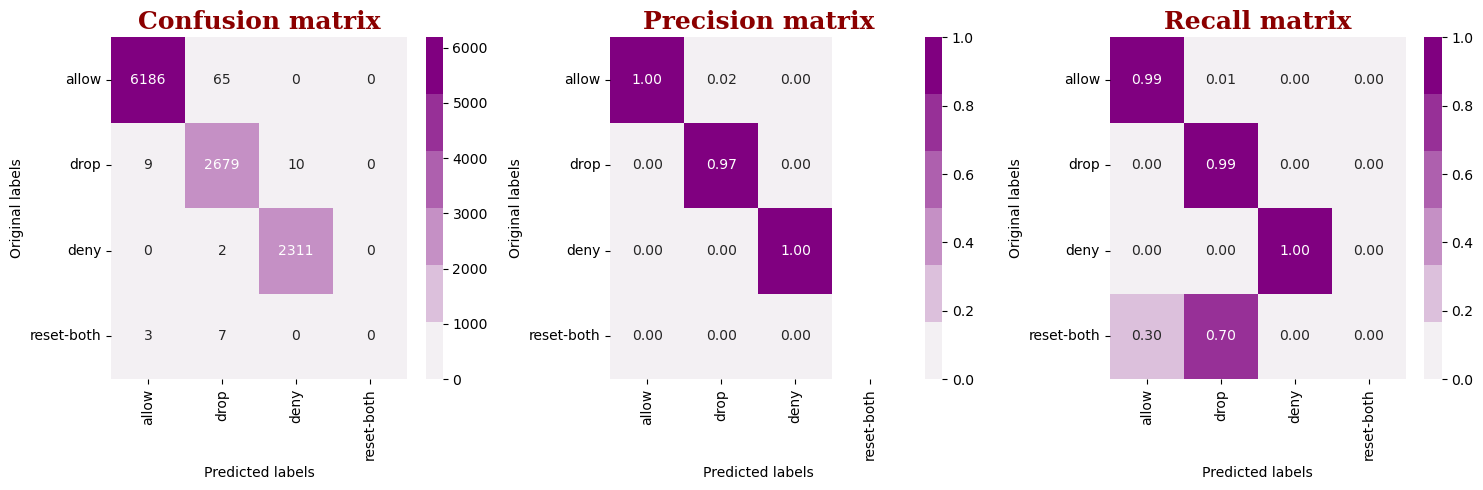

In [52]:
# training the classifier on training data
knn = KNeighborsClassifier(n_neighbors = 8, weights = 'distance')
knn.fit(X_train_preprocessed, y_train)

# calibrating the classifier on validation data
calibrator_knn = CalibratedClassifierCV(knn, method = 'isotonic', cv = 'prefit')
calibrator_knn.fit(X_cv_preprocessed, y_cv)

# evaluating the classifier on test data
y_train_probs = calibrator_knn.predict_proba(X_train_preprocessed)
y_cv_probs = calibrator_knn.predict_proba(X_cv_preprocessed)
y_test_probs = calibrator_knn.predict_proba(X_test_preprocessed)

train_loss_knn = log_loss(y_train, y_train_probs)
cv_loss_knn = log_loss(y_cv, y_cv_probs)
test_loss_knn = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using K-Nearest Neighbors Model: {train_loss_knn}")
print(f"Log loss on Validation Data using K-Nearest Neighbors Model: {cv_loss_knn}")
print(f"Log loss on Test Data using K-Nearest Neighbors Model: {test_loss_knn}")

y_test_preds = calibrator_knn.predict(X_test_preprocessed)
plot_confusion_matrix(y_test, y_test_preds)

Comme nous pouvons le voir, le modèle a une perte logarithmique de 0,028, ce qui est très faible par rapport à 1,45 pour le modèle de base. Cependant, même si le modèle réussit très bien à classer toutes les classes d'action à l'exception de « reset-both », il est possible qu'il ait des difficultés parce qu'il n'y a que 10 instances de cette classe dans les données de test. Il est possible qu'il éprouve des difficultés parce qu'il n'y a que 10 instances de cette classe dans les données de test.

### **5.4 Logistic Regression**

La régression logistique est un modèle de classification qui tente explicitement de minimiser la perte logarithmique. Le paramètre « C » contrôle l'importance de la régularisation, les valeurs les plus petites entraînant une régularisation plus importante. Le paramètre 'penalty' contrôle le type de régularisation.

In [52]:
from sklearn.linear_model import LogisticRegression

# tuning the hyperparameters on training data
log_parameters = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
log = LogisticRegression(class_weight = 'balanced', max_iter=2000, n_jobs = -1, random_state = 859)
random_search_log = RandomizedSearchCV(estimator = log, param_distributions = log_parameters, n_iter=50, n_jobs = -1, random_state = 859)
random_search_log.fit(X_train_preprocessed, y_train)
print(random_search_log.best_params_)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'penalty': 'l2', 'C': 0.01}


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Log loss on Train Data using Logistic Regression Model: 0.24114198017077818
Log loss on Validation Data using Logistic Regression Model: 0.22943861663705736
Log loss on Test Data using Logistic Regression Model: 0.2522364939945061




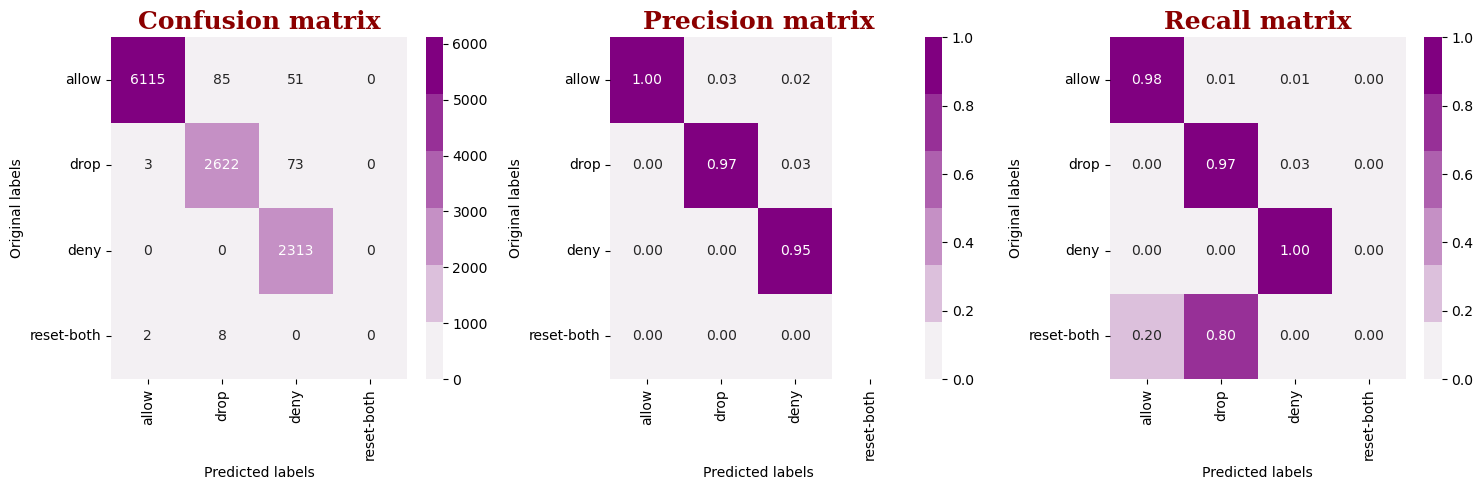

In [51]:
# training the classifier on training data
logistic = LogisticRegression(C = 1, penalty = 'l2', class_weight = 'balanced', n_jobs = -1, random_state = 859)
logistic.fit(X_train_preprocessed, y_train)

# calibrating the classifier on validation data
calibrator_logistic = CalibratedClassifierCV(logistic, method = 'isotonic', cv = 'prefit')
calibrator_logistic.fit(X_cv_preprocessed, y_cv)

# # evaluating the classifier on test data
y_train_probs = calibrator_logistic.predict_proba(X_train_preprocessed)
y_cv_probs = calibrator_logistic.predict_proba(X_cv_preprocessed)
y_test_probs = calibrator_logistic.predict_proba(X_test_preprocessed)

train_loss_logistic = log_loss(y_train, y_train_probs)
cv_loss_logistic = log_loss(y_cv, y_cv_probs)
test_loss_logistic = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using Logistic Regression Model: {train_loss_logistic}")
print(f"Log loss on Validation Data using Logistic Regression Model: {cv_loss_logistic}")
print(f"Log loss on Test Data using Logistic Regression Model: {test_loss_logistic}")

y_test_preds = calibrator_logistic.predict(X_test_preprocessed)
plot_confusion_matrix(y_test, y_test_preds)

Comme nous pouvons le voir, le modèle a une perte logarithmique de test de 0,38, ce qui est faible par rapport à 1,45 pour le modèle de base, mais plus élevé que 0,028 pour le modèle de KNN. De même, comme pour les KNN, le modèle réussit très bien à classer toutes les classes d'action, à l'exception de la classe « reset-both». Il se peut qu'il ait des difficultés parce qu'il n'y a que 10 instances de cette classe dans les données de test.

### **5.5 Support Vector CLassifier**

Le SGDClassifier est un modèle de classification qui tente explicitement de minimiser la perte de charnière. Il s'agit donc principalement d'un classificateur de vecteurs de supprot avec un noyau linéaire. Nous n'utilisons pas de vecteurs supprot avec un noyau rbf en raison du nombre élevé d'échantillons d'apprentissage. Le paramètre « alpha » contrôle l'importance de la régularisation, les valeurs les plus faibles entraînant une régularisation moindre. Le paramètre 'penalty' contrôle le type de régularisation.

In [49]:
from sklearn.linear_model import SGDClassifier

# tuning the hyperparameters on training data
svc_parameters = {'alpha': [0.0001, 0.01, 1, 100, 10000], 'penalty': ['l1', 'l2']}
svc = SGDClassifier(class_weight = 'balanced', n_jobs = -1, random_state = 859)
random_search_svc = RandomizedSearchCV(estimator = svc, param_distributions = svc_parameters, n_jobs = -1, random_state = 859)
random_search_svc.fit(X_train_preprocessed, y_train)
print(random_search_svc.best_params_)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_stochastic

{'penalty': 'l1', 'alpha': 1}


Log loss on Train Data using Support Vectors Model: 0.1054962353442097
Log loss on Validation Data using Support Vectors Model: 0.10119354674678184
Log loss on Test Data using Support Vectors Model: 0.11540599374637499




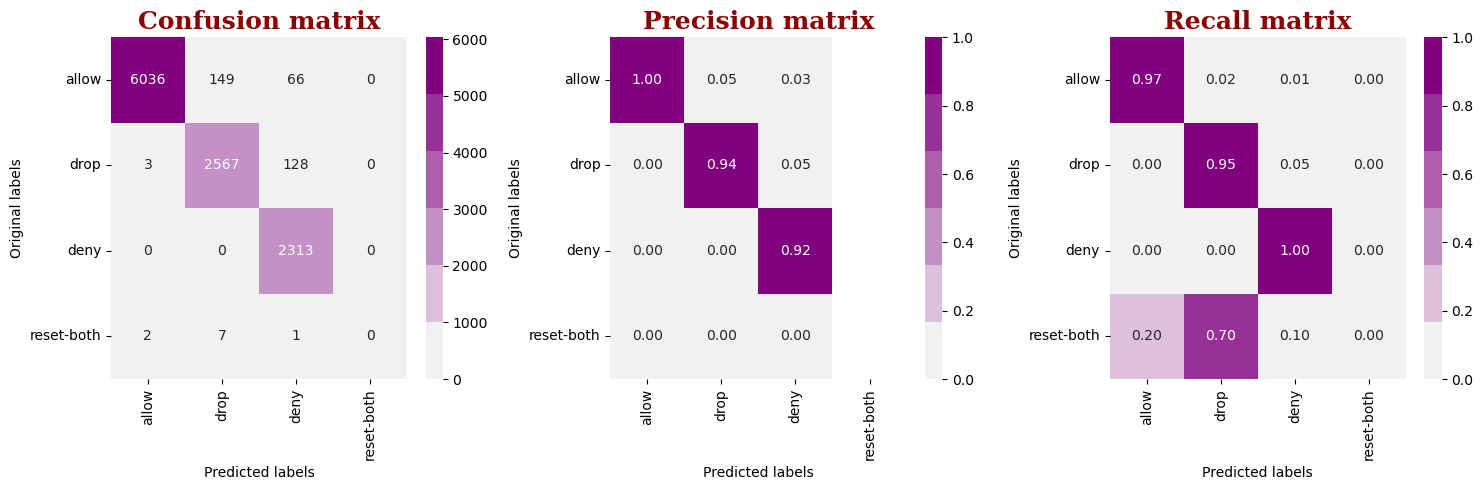

In [50]:
# training the classifier on training data
svc = SGDClassifier(alpha = 1, penalty = 'l1', class_weight = 'balanced', n_jobs = -1, random_state = 859)
svc.fit(X_train_preprocessed, y_train)

# calibrating the classifier on validation data
calibrator_svc = CalibratedClassifierCV(svc, method = 'isotonic', cv = 'prefit')
calibrator_svc.fit(X_cv_preprocessed, y_cv)

# calibrating the classifier on test data
y_train_probs = calibrator_svc.predict_proba(X_train_preprocessed)
y_cv_probs = calibrator_svc.predict_proba(X_cv_preprocessed)
y_test_probs = calibrator_svc.predict_proba(X_test_preprocessed)

train_loss_svc = log_loss(y_train, y_train_probs)
cv_loss_svc = log_loss(y_cv, y_cv_probs)
test_loss_svc = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using Support Vectors Model: {train_loss_svc}")
print(f"Log loss on Validation Data using Support Vectors Model: {cv_loss_svc}")
print(f"Log loss on Test Data using Support Vectors Model: {test_loss_svc}")

y_test_preds = calibrator_svc.predict(X_test_preprocessed)
plot_confusion_matrix(y_test, y_test_preds)

Comme nous pouvons le voir, le modèle a une perte logarithmique de 0,09, ce qui est faible par rapport à 1,45 pour le modèle de base, mais plus élevé que 0,028 pour le modèle de KNN. De même, comme pour les KNN, le modèle réussit très bien à classer toutes les classes d'action, à l'exception de la classe «reset-both». Il se peut qu'il ait des difficultés parce qu'il n'y a que 10 instances de cette classe dans les données de test.

### **5.6 Random Forest Classifier**

Le RandomForestClassifier est un modèle d'ensemble qui forme un grand ensemble d'arbres de décision. Le paramètre « n_estimators » détermine le nombre d'arbres de décision à former. Le paramètre 'criterion' contrôle la métrique de gain d'information sur laquelle diviser l'arbre. max_depth » est le nombre maximum de niveaux d'arbres autorisés dans la construction des arbres de décision.

In [56]:
from sklearn.ensemble import RandomForestClassifier

# tuning the hyperparameters on training data
rf_parameters = {'n_estimators': [100, 500, 1000, 2000], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, 20, 25]}
rf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1, random_state = 859)
random_search_rf = RandomizedSearchCV(estimator = rf, param_distributions = rf_parameters, n_jobs = -1, random_state = 859)
random_search_rf.fit(X_train_preprocessed, y_train)
print(random_search_rf.best_params_)

{'n_estimators': 2000, 'max_depth': 20, 'criterion': 'entropy'}


Log loss on Train Data using Random Forest Classifier Model: 0.004331933639476276
Log loss on Validation Data using Random Forest Classifier Model: 0.007455979686132697
Log loss on Test Data using Random Forest Classifier Model: 0.01358374299895294




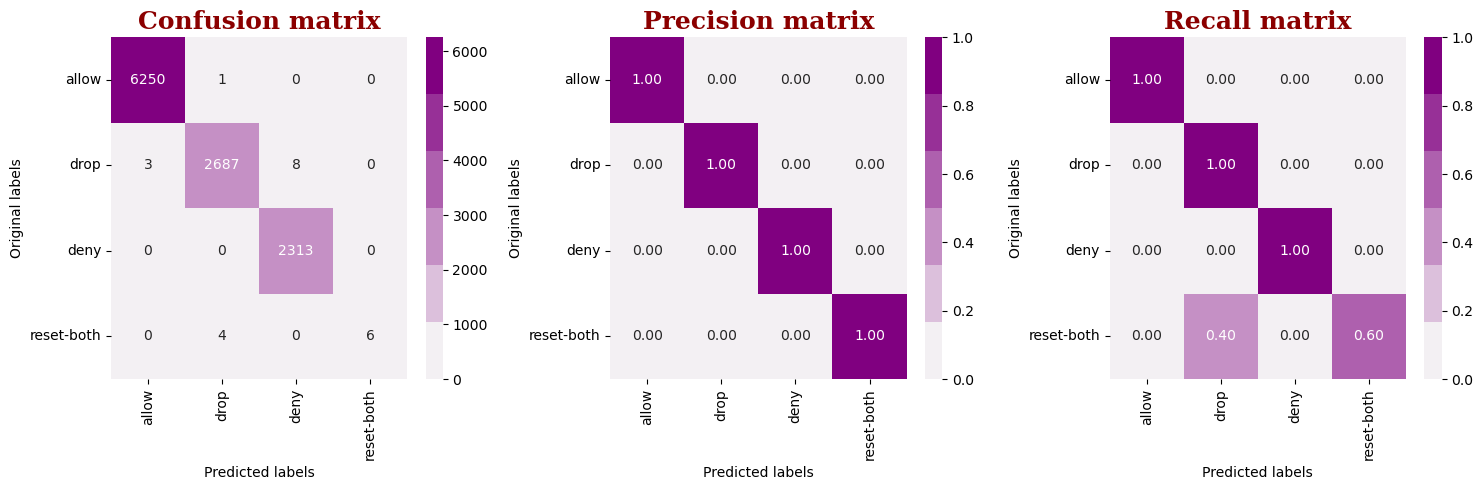

In [47]:
# training the classifier on training data
rf = RandomForestClassifier(n_estimators = 2000, max_depth = 20, criterion = 'entropy', class_weight = 'balanced', n_jobs = -1, random_state = 859)
rf.fit(X_train_preprocessed, y_train)

# calibrating the classifier on validation data
calibrator_rf = CalibratedClassifierCV(rf, method = 'isotonic', cv = 'prefit')
calibrator_rf.fit(X_cv_preprocessed, y_cv)

# evaluating the classifier on test data
y_train_probs = calibrator_rf.predict_proba(X_train_preprocessed)
y_cv_probs = calibrator_rf.predict_proba(X_cv_preprocessed)
y_test_probs = calibrator_rf.predict_proba(X_test_preprocessed)

train_loss_rf = log_loss(y_train, y_train_probs)
cv_loss_rf = log_loss(y_cv, y_cv_probs)
test_loss_rf = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using Random Forest Classifier Model: {train_loss_rf}")
print(f"Log loss on Validation Data using Random Forest Classifier Model: {cv_loss_rf}")
print(f"Log loss on Test Data using Random Forest Classifier Model: {test_loss_rf}")

y_test_preds = calibrator_rf.predict(X_test_preprocessed)
plot_confusion_matrix(y_test, y_test_preds)

Comme nous pouvons le voir, le modèle a une perte logarithmique de 0,009, ce qui est très faible par rapport à 1,45 pour le modèle de base et à 0,028 pour le modèle de KNN. En outre, contrairement aux KNN, le modèle réussit très bien à classer toutes les classes d'action, y compris la classe « reset-both ». Comme il semble s'agir d'un bon modèle, vérifions l'importance des caractéristiques dans la prédiction de la classe d'action.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


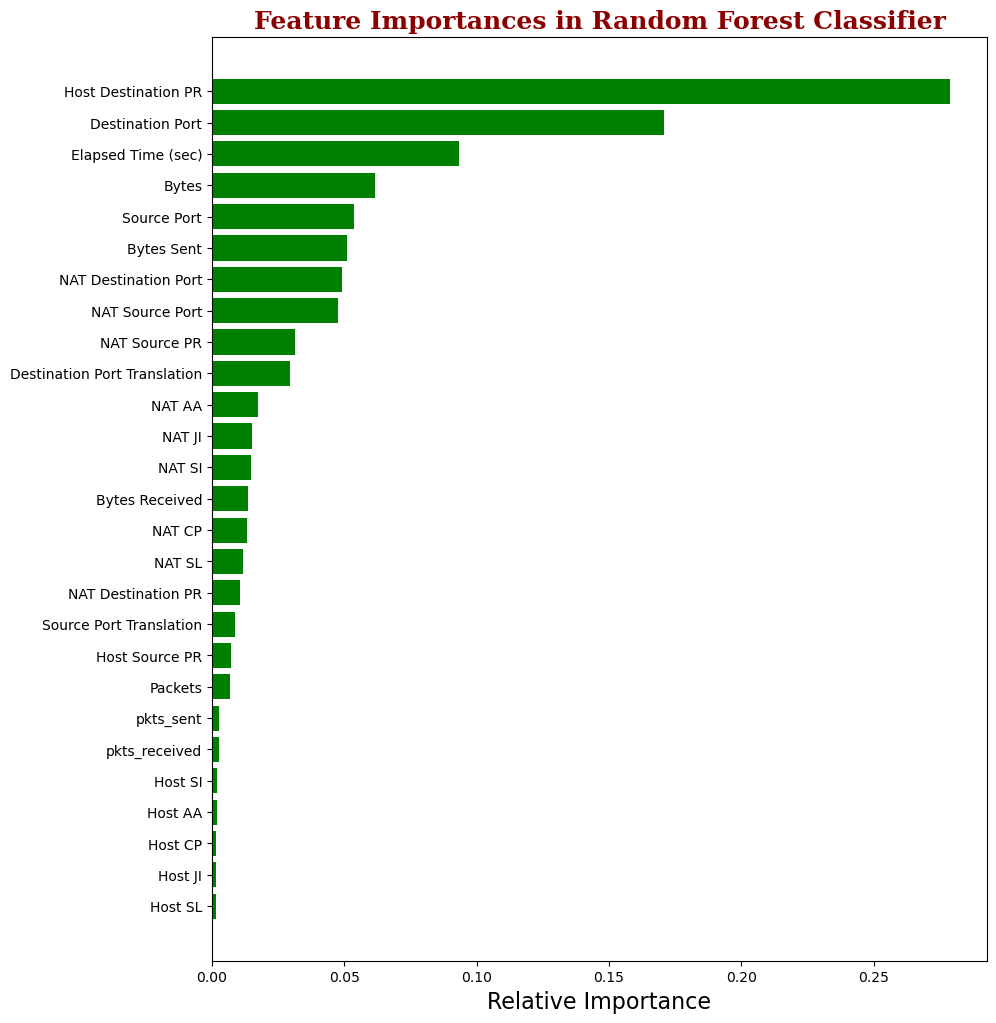

In [58]:
# list of features
features = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port',
            'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
            'pkts_received', 'Host Source PR', 'Host Destination PR', 'NAT Source PR', 'NAT Destination PR',
            'Host CP', 'NAT CP', 'Host JI', 'NAT JI', 'Host SL', 'NAT SL', 'Host SI', 'NAT SI', 'Host AA',
            'NAT AA', 'Source Port Translation', 'Destination Port Translation']
# array of feature importances
importances = rf.feature_importances_
# sorting indices of importances in decreasing order
indices = (np.argsort(importances))
# plotting the horizontal barplot
plt.figure(figsize=(10,12))
plt.title('Feature Importances in Random Forest Classifier', fontdict = title_font)
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontdict = label_font)
plt.show()

Notamment, de nombreuses caractéristiques techniques sont très importantes pour la classification des logs. En particulier, les caractéristiques Page rank et Adamic-Adar index sont très importantes.

### **5.7 Light GBM Classifier**

Le LGBMClassifier est également un modèle d'ensemble qui entraîne un grand ensemble d'arbres de décision. Le paramètre 'n_estimators' contrôle le nombre d'arbres de décision à former. Le paramètre « objective » spécifie la tâche d'apprentissage, qui est « multiclasse » dans notre cas. max_depth » est le nombre maximal de niveaux d'arbres autorisés dans la construction des arbres de décision.

In [81]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# tuning the hyperparameters on training data
lgbm_parameters = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
lgbm = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced', verbose=-1, force_col_wise=True, max_bin=255, n_jobs = 1, random_state = 859)
random_search_lgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = lgbm_parameters, verbose=False, n_iter=50, n_jobs = 1, random_state = 859)
random_search_lgbm.fit(X_train_preprocessed, y_train)
print(random_search_lgbm.best_params_)

{'n_estimators': 200, 'max_depth': 5}


Log loss on Train Data using Light GBM Classifier Model: 0.004112617106013398
Log loss on Validation Data using Light GBM Classifier Model: 0.006164959643974712
Log loss on Test Data using Light GBM Classifier Model: 0.01868521202256256




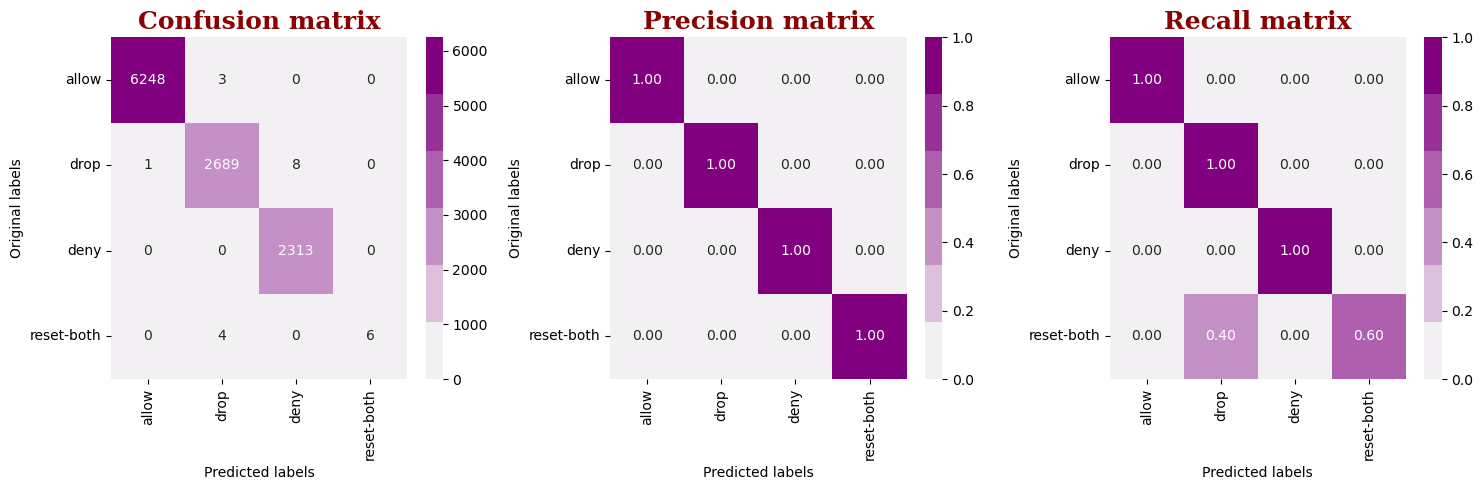

In [46]:

# training the classifier on training data
lgbm = LGBMClassifier(n_estimators = 200, max_depth = 5, objective = 'multiclass', verbose=-1, class_weight = 'balanced', n_jobs = -1, random_state = 859)
lgbm.fit(X_train_preprocessed, y_train)

# calibrating the classifier on validation data
calibrator_lgbm = CalibratedClassifierCV(lgbm, method = 'isotonic', cv = 'prefit')
calibrator_lgbm.fit(X_cv_preprocessed, y_cv)

# evaluating the classifier on test data
y_train_probs = calibrator_lgbm.predict_proba(X_train_preprocessed)
y_cv_probs = calibrator_lgbm.predict_proba(X_cv_preprocessed)
y_test_probs = calibrator_lgbm.predict_proba(X_test_preprocessed)

train_loss_lgbm = log_loss(y_train, y_train_probs)
cv_loss_lgbm = log_loss(y_cv, y_cv_probs)
test_loss_lgbm = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using Light GBM Classifier Model: {train_loss_lgbm}")
print(f"Log loss on Validation Data using Light GBM Classifier Model: {cv_loss_lgbm}")
print(f"Log loss on Test Data using Light GBM Classifier Model: {test_loss_lgbm}")

y_test_preds = calibrator_lgbm.predict(X_test_preprocessed)
plot_confusion_matrix(y_test, y_test_preds)

Comme nous pouvons le voir, le modèle a une perte logarithmique de 0,008, ce qui est très faible par rapport à 1,45 pour le modèle de base et également inférieur à 0,009 pour le modèle de forêt aléatoire. En outre, le modèle réussit très bien à classer toutes les classes d'action, y compris « reset-both ». Comme ce modèle semble être le meilleur, vérifions l'importance des caractéristiques dans la prédiction de la classe d'action.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


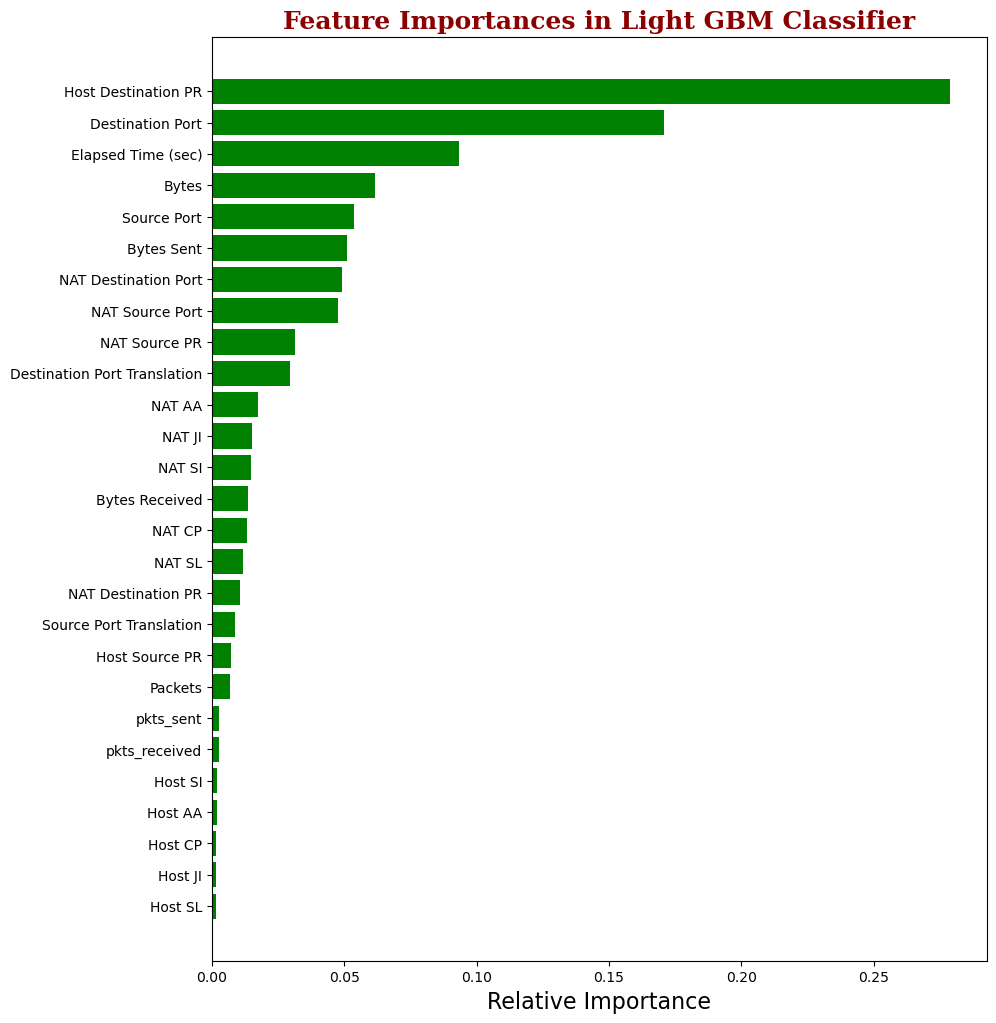

In [84]:
# list of features
features = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port',
            'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
            'pkts_received', 'Host Source PR', 'Host Destination PR', 'NAT Source PR', 'NAT Destination PR',
            'Host CP', 'NAT CP', 'Host JI', 'NAT JI', 'Host SL', 'NAT SL', 'Host SI', 'NAT SI', 'Host AA',
            'NAT AA', 'Source Port Translation', 'Destination Port Translation']
# array of feature importances
importances = rf.feature_importances_
# sorting indices of importances in decreasing order
indices = (np.argsort(importances))
# plotting the horizontal barplot
plt.figure(figsize=(10,12))
plt.title('Feature Importances in Light GBM Classifier', fontdict = title_font)
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontdict = label_font)
plt.show()

Notamment, de nombreuses caractéristiques techniques sont très importantes pour la classification des logs. En particulier, les caractéristiques de classement des pages (pages rank) et de traduction (NAT) sont très importantes.

### **5.8 Adaboost Classifier**

Le classificateur Adaboost est également un modèle d'ensemble qui forme un grand ensemble d'arbres de décision. Le paramètre 'n_estimators' contrôle le nombre d'arbres de décision à former.

In [59]:
from sklearn.ensemble import AdaBoostClassifier

# tuning the hyperparameters on training data
adaboost_parameters = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.1, 0.5, 1, 1.5, 2]}
adaboost = AdaBoostClassifier(random_state = 859)
random_search_adaboost = RandomizedSearchCV(estimator = adaboost, param_distributions = adaboost_parameters, n_jobs = -1, random_state = 859)
random_search_adaboost.fit(X_train_preprocessed, y_train)
print(random_search_adaboost.best_params_)

{'n_estimators': 50, 'learning_rate': 0.1}


Log loss on Train Data using Random Forest Classifier Model: 0.10701462779646018
Log loss on Validation Data using Random Forest Classifier Model: 0.10574393105175148
Log loss on Test Data using Random Forest Classifier Model: 0.11762158586966981




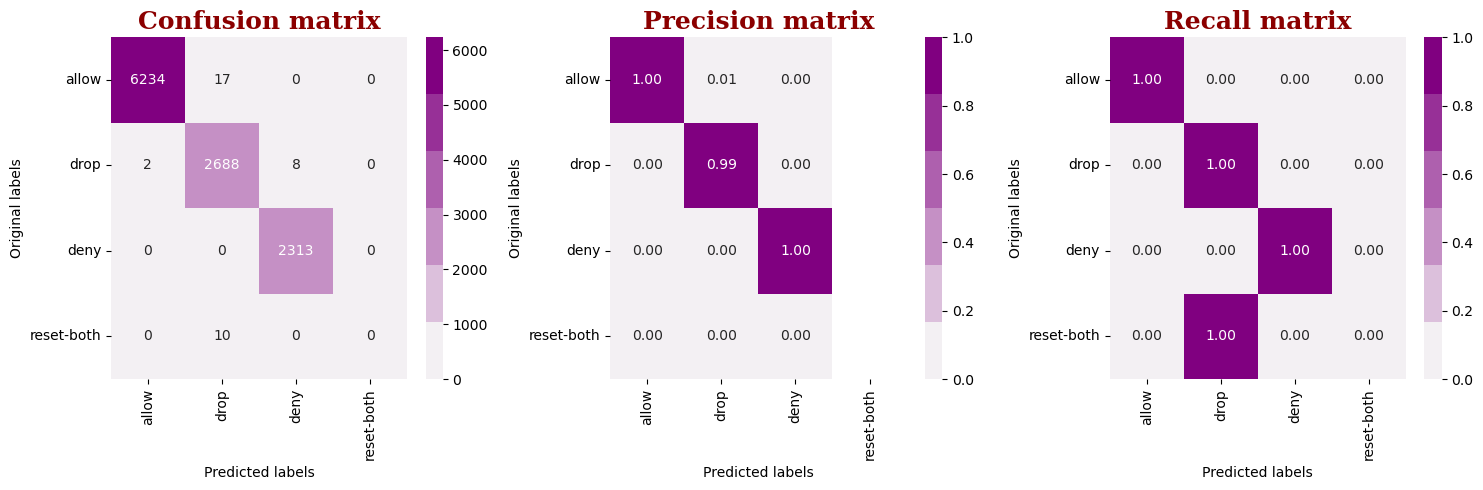

In [45]:
# training the classifier on training data
adaboost = AdaBoostClassifier(n_estimators = 50, learning_rate = 0.1, random_state = 859)
adaboost.fit(X_train_preprocessed, y_train)

# calibrating the classifier on validation data
calibrator_adaboost = CalibratedClassifierCV(adaboost, method = 'isotonic', cv = 'prefit')
calibrator_adaboost.fit(X_cv_preprocessed, y_cv)

# evaluating the classifier on test data
y_train_probs = calibrator_adaboost.predict_proba(X_train_preprocessed)
y_cv_probs = calibrator_adaboost.predict_proba(X_cv_preprocessed)
y_test_probs = calibrator_adaboost.predict_proba(X_test_preprocessed)

train_loss_adaboost = log_loss(y_train, y_train_probs)
cv_loss_adaboost = log_loss(y_cv, y_cv_probs)
test_loss_adaboost = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using Random Forest Classifier Model: {train_loss_adaboost}")
print(f"Log loss on Validation Data using Random Forest Classifier Model: {cv_loss_adaboost}")
print(f"Log loss on Test Data using Random Forest Classifier Model: {test_loss_adaboost}")

y_test_preds = calibrator_adaboost.predict(X_test_preprocessed)
plot_confusion_matrix(y_test, y_test_preds)

Comme nous pouvons le voir, le modèle a une perte logarithmique de test de 0,107, ce qui est très faible par rapport à 1,45 pour le modèle de base, mais pas mieux que 0,008 pour le modèle Light GBM. De plus, le modèle réussit très bien à classer toutes les classes d'action, mais il a du mal à classer « reset-both ».

### **5.9 Multi Layered Perceptron Classifier**

Outre les réseaux d'apprentissage automatique, nous pouvons également essayer un réseau neuronal simple connu sous le nom de perceptron multicouche en utilisant l'API séquentielle de la bibliothèque tensorflow. La couche comprendra une couche d'entrée normalisée par lots, suivie de quelques blocs de couches denses et d'abandon.

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential

# designing the MLP architechture
IN_SHAPE = X_train_preprocessed.shape[-1]
NUM_CLASSES = 4
model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(IN_SHAPE,), name = "Input"),
        tf.keras.layers.BatchNormalization(name = "BN"),
        tf.keras.layers.Dense(128, activation='relu', name = "Dense_1"),
        tf.keras.layers.Dropout(0.2, name = "Dropout_1"),
        tf.keras.layers.Dense(64, activation='relu', name = "Dense_2"),
        tf.keras.layers.Dropout(0.2, name = "Dropout_2"),
        tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax', name = "Output")
        ], name = "MLP_Model")
model.summary()

2025-04-13 17:49:14.813203: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 17:49:14.874285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-13 17:49:14.874342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-13 17:49:14.874394: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 17:49:14.887720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 17:49:14.890726: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Model: "MLP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BN (BatchNormalization)     (None, 27)                108       
                                                                 
 Dense_1 (Dense)             (None, 128)               3584      
                                                                 
 Dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Dense_2 (Dense)             (None, 64)                8256      
                                                                 
 Dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 Output (Dense)              (None, 4)                 260       
                                                                 
Total params: 12208 (47.69 KB)
Trainable params: 12154 (4

Pour former le modèle MLP, la matrice des caractéristiques d'entrée doit être convertie en type de données flottantes et le vecteur cible de sortie doit être converti en une matrice peu dense.

In [34]:

# changing dtype of input features to float
X_train_encoded = X_train_preprocessed.astype(float)
X_cv_encoded = X_cv_preprocessed.astype(float)
X_test_encoded = X_test_preprocessed.astype(float)

# encoding target vectors into sparse matrices
encoder = dict(zip(np.sort(y_train.unique()), list(range(4))))
# encoder = dictionary with class labels as keys and integer as values
def encode(y):
    return encoder[y]
y_train_coded = y_train.apply(encode)
y_cv_coded = y_cv.apply(encode)
y_test_coded = y_test.apply(encode)
y_train_encoded = tf.keras.utils.to_categorical(y_train_coded)
y_cv_encoded = tf.keras.utils.to_categorical(y_cv_coded)
y_test_encoded = tf.keras.utils.to_categorical(y_test_coded)

In [35]:
BATCH_SIZE = 1024
EPOCHS = 100

# designing callbacks to control training of MLP
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 0.001)
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MLP.h5", monitor = 'val_loss', save_best_only = True)
def create_tensorboard_cb(model):
    import time
    import os
    root_logdir = os.path.join(os.curdir, model)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    logdir = os.path.join(root_logdir, run_id)
    return tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)
tensorboard_cb = create_tensorboard_cb("MLP_logs")
CALLBACKS = [reduce_lr, stopper, checkpoint_cb, tensorboard_cb]

# fitting the MLP on training data using categorical crossentropy as loss function which is explicitly similar to muticlass log loss
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
model.fit(x = X_train_encoded, y = y_train_encoded, batch_size = BATCH_SIZE, epochs = EPOCHS, callbacks = CALLBACKS, validation_data = (X_cv_encoded, y_cv_encoded))

Epoch 1/100
45/45 [==============================] - 2s 22ms/step - loss: 0.3980 - val_loss: 0.1681 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0604 - val_loss: 0.0701 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0476 - val_loss: 0.0467 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 1s 15ms/step - loss: 0.0424 - val_loss: 0.0396 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 1s 13ms/step - loss: 0.0380 - val_loss: 0.0366 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0352 - val_loss: 0.0318 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - 1s 17ms/step - loss: 0.0317 - val_loss: 0.0300 - lr: 0.0010
Epoch 8/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0307 - val_loss: 0.0280 - lr: 0.0010
Epoch 9/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0283 - val_loss: 0.0

353/353 [==============================] - 1s 3ms/step
Log loss on Train Data using MLP Model: 0.010619969834010244
Log loss on Validation Data using Random MLP Model: 0.014642459795273594
Log loss on Test Data using MLP Model: 0.012946863822135633




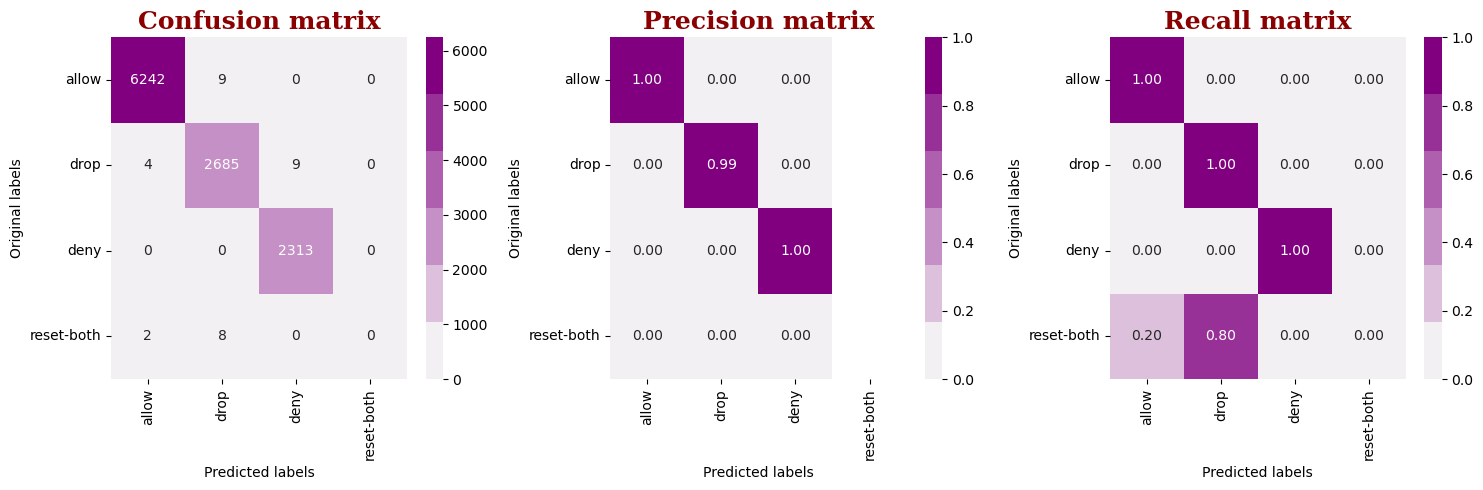

In [38]:
# evaluating MLP on test data
y_train_probs = model.predict(X_train_encoded)
y_cv_probs = model.predict(X_cv_encoded)
y_test_probs = model.predict(X_test_encoded)
train_loss_mlp = log_loss(y_train, y_train_probs)
cv_loss_mlp = log_loss(y_cv, y_cv_probs)
test_loss_mlp = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using MLP Model: {train_loss_mlp}")
print(f"Log loss on Validation Data using Random MLP Model: {cv_loss_mlp}")
print(f"Log loss on Test Data using MLP Model: {test_loss_mlp}")

decoder = dict(zip(list(range(4)), np.sort(y_train.unique())))
# decoder = dictionary with integers as keys and class label as values
y_test_preds_indices = np.argmax(y_test_probs, axis = 1)
# predictions from MLP are probabilities of particular class labels hence, getting class with maximum probability
y_test_preds = np.array([decoder[i] for i in y_test_preds_indices])
# getting class labels using decoder dictionary
plot_confusion_matrix(y_test, y_test_preds)

Comme nous pouvons le voir, le modèle a une perte logarithmique de test de 0,011, ce qui est très faible par rapport à 1,45 pour le modèle de base, mais pas mieux que 0,008 pour le modèle Light GBM. De plus, le modèle réussit très bien à classer toutes les classes d'action, mais il a du mal à classer « reset-both ».

### **5.10 Stacking Classifier**

Le StackingClassifier est une technique d'apprentissage d'ensemble qui permet de combiner plusieurs modèles de classification par l'intermédiaire d'un méta-classificateur. Nous pouvons utiliser des modèles performants comme KNeighbours, RandomForest, LightGBM et Adaboost comme modèles de base et LogisticRegression comme méta-classificateur pour minimiser la perte logarithmique. Les hyperparamètres du classificateur d'empilage peuvent être réglés à l'aide de la technique RandomizedSearchCV.

Log loss on Train Data using Stacking Classifier Model: 0.014701092287369991
Log loss on Validation Data using Stacking Classifier Model: 0.01749651615438459
Log loss on Test Data using Stacking Classifier Model: 0.017520601430495122




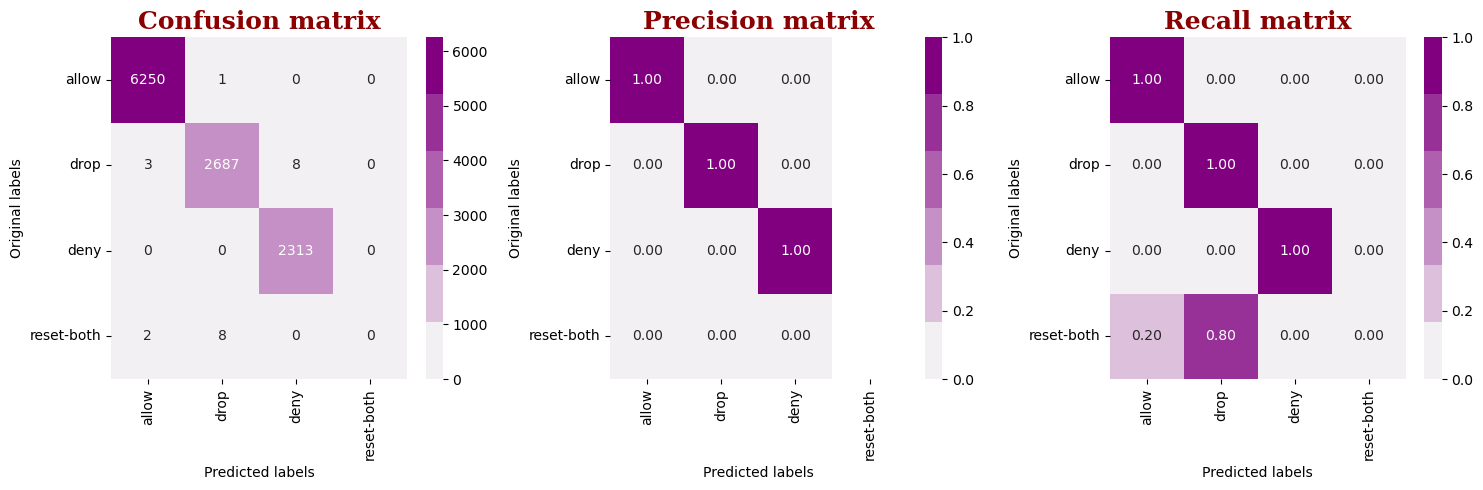

In [43]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# training the classifier on training data
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors = 8)),
    ('rf', RandomForestClassifier(n_estimators = 800, max_depth = 10, random_state = 859)),
    ('lgbm', LGBMClassifier(n_estimators = 150, max_depth = 5, verbose=-1, force_col_wise=True, max_bin=255, n_jobs = 1, random_state = 859)),
    ('ada', AdaBoostClassifier(n_estimators = 50, learning_rate = 0.1, random_state = 859))
]
lr = LogisticRegression(C = 0.01, random_state = 859)
stacking = StackingClassifier(estimators = estimators,
                          final_estimator = lr)
stacking.fit(X_train_preprocessed, y_train_coded)

# evaluating the classifier on test data
y_train_probs = stacking.predict_proba(X_train_preprocessed)
y_cv_probs = stacking.predict_proba(X_cv_preprocessed)
y_test_probs = stacking.predict_proba(X_test_preprocessed)

train_loss_stacking = log_loss(y_train, y_train_probs)
cv_loss_stacking = log_loss(y_cv, y_cv_probs)
test_loss_stacking = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using Stacking Classifier Model: {train_loss_stacking}")
print(f"Log loss on Validation Data using Stacking Classifier Model: {cv_loss_stacking}")
print(f"Log loss on Test Data using Stacking Classifier Model: {test_loss_stacking}")

y_test_preds_indices = stacking.predict(X_test_preprocessed)
# getting class labels using decoder dictionary
y_test_preds = np.array([decoder[i] for i in y_test_preds_indices])
plot_confusion_matrix(y_test, y_test_preds)

Comme nous pouvons le voir, le modèle a une perte logarithmique de 0,0107, ce qui est très faible par rapport à 1,45 pour le modèle de base, mais pas mieux que 0,008 pour le modèle Light GBM. En outre, le modèle réussit très bien à classer toutes les classes d'action, y compris « Reset-both ». Le meilleur modèle peut donc être choisi en calculant la complexité d'exécution.

### **5.11 Summary of the performance of models**

Nous pouvons maintenant comparer les performances de tous les modèles en fonction d'attributs tels que le train loss, test loss et le temps d'exécution pour prédire la classe Action.

In [53]:
import time
def check(model, vector):
    """
    Checks the run-time complexity of the model for a single log data. Gives mean of 100 test runs for reliability

    Args:
        model: Instance of the ML model
        vector: vector of log data

    Returns:
        Mean run time of prediction
    """
    times = []
    for i in range(100):
        t = time.time()
        pred = model.predict(vector)
        times.append(time.time() - t)
    return np.round(np.mean(times), 4)

# storing run times for all the models in dictionary
elapsed_times= {}
elapsed_times['KNeighbors Classifier'] = check(calibrator_knn, X_test_preprocessed[0].reshape(1, -1))
elapsed_times['Logistic Regression'] = check(logistic, X_test_preprocessed[0].reshape(1, -1))
elapsed_times['Support Vectors'] = check(calibrator_svc, X_test_preprocessed[0].reshape(1, -1))
elapsed_times['Random Forest Classifier'] = check(calibrator_rf, X_test_preprocessed[0].reshape(1, -1))
elapsed_times['Light GBM Classifier'] = check(calibrator_lgbm, X_test_preprocessed[0].reshape(1, -1))
elapsed_times['Adaboost Classifier'] = check(calibrator_adaboost, X_test_preprocessed[0].reshape(1, -1))
elapsed_times['MLP Classifier'] = check(model, X_test_encoded[0].reshape(1, -1))
elapsed_times['Stacking Classifier'] = check(stacking, X_test_preprocessed[0].reshape(1, -1))

1/1 [==============================] - 0s 41ms/step


In [55]:
from prettytable import PrettyTable

# summarizing the results in table
x = PrettyTable()

x.field_names = ["Sr. No.", "Classifier", "Train Log-Loss", "Test Log-Loss", "Run-time (sec)"]

x.add_row([1, 'KNeighbors Classifier', np.round(train_loss_knn, 4), np.round(test_loss_knn, 4), elapsed_times['KNeighbors Classifier']])
x.add_row([2, 'Logistic Regression', np.round(train_loss_logistic, 4), np.round(test_loss_logistic, 4), elapsed_times['Logistic Regression']])
x.add_row([3, 'Support Vectors', np.round(train_loss_svc, 4), np.round(test_loss_svc, 4), elapsed_times['Support Vectors']])
x.add_row([4, 'Random Forest Classifier', np.round(train_loss_rf, 4), np.round(test_loss_rf, 4), elapsed_times['Random Forest Classifier']])
x.add_row([5, 'Light GBM Classifier', np.round(train_loss_lgbm, 4), np.round(test_loss_lgbm, 4), elapsed_times['Light GBM Classifier']])
x.add_row([6, 'Adaboost Classifier', np.round(train_loss_adaboost, 4), np.round(test_loss_adaboost, 4), elapsed_times['Adaboost Classifier']])
x.add_row([7, 'MLP Classifier', np.round(train_loss_mlp, 4), np.round(test_loss_mlp, 4), elapsed_times['MLP Classifier']])
x.add_row([8, 'Stacking Classifier', np.round(train_loss_stacking, 4), np.round(test_loss_stacking, 4), elapsed_times['Stacking Classifier']])

print(x)

+---------+--------------------------+----------------+---------------+----------------+
| Sr. No. |        Classifier        | Train Log-Loss | Test Log-Loss | Run-time (sec) |
+---------+--------------------------+----------------+---------------+----------------+
|    1    |  KNeighbors Classifier   |     0.004      |     0.0356    |     0.0225     |
|    2    |   Logistic Regression    |     0.2411     |     0.2522    |     0.0001     |
|    3    |     Support Vectors      |     0.1055     |     0.1154    |     0.0009     |
|    4    | Random Forest Classifier |     0.0043     |     0.0136    |     0.4075     |
|    5    |   Light GBM Classifier   |     0.0041     |     0.0187    |     0.0033     |
|    6    |   Adaboost Classifier    |     0.107      |     0.1176    |     0.009      |
|    7    |      MLP Classifier      |     0.0106     |     0.0129    |     0.0896     |
|    8    |   Stacking Classifier    |     0.0147     |     0.0175    |     0.0754     |
+---------+----------

Les résultats montrent clairement que le classificateur GBM léger est le meilleur modèle avec une perte de log de test de 0,0083 et un temps d'exécution de seulement 0,0009 seconde. Le modèle répond donc à l'exigence de faible latence tout en étant capable de produire des prédictions fiables sur les journaux de trafic du pare-feu.

## **6 Déploiement du model**

Le modèle peut maintenant être déployé en production en créant des scripts avec des pipelines de traitement de données appropriés. Nous allons créer deux scripts pour le déploiement. Le premier script Model.py entraînera le meilleur modèle sur les données et le second script App.py implémentera l'api flask pour le déploiement.

### **6.1 Model.py**

In [ ]:
import pandas as pd
import numpy as np
import joblib
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import networkx as nx

###################################################

# reading dataframe
data = pd.read_csv("log2.csv")
# removing instances where Bytes are beyond 99th percentile
data = data[data['Bytes'] <= np.percentile(data['Bytes'], 99)]
# removing instances where Packets are beyond 99th percentile
data = data[data['Packets'] <= np.percentile(data['Packets'], 99)]
# removing instances where Elapsed Time (sec) are beyond 99th percentile
data = data[data['Elapsed Time (sec)'] <= np.percentile(data['Elapsed Time (sec)'], 99)]
# adding translation features
data['Source Port Translation'] = (data['Source Port'] != data['NAT Source Port']).astype('int')
data['Destination Port Translation'] = (data['Destination Port'] != data['NAT Destination Port']).astype('int')

# building bidirectional graph by using port numbers on host devices
HOST_NW = nx.DiGraph(name = "Host")
HOST_NW.add_edges_from(data[['Source Port', 'Destination Port']].values)
joblib.dump(HOST_NW, 'host_nw.pkl')
# building bidirectional graph by using port numbers on NAT 
NAT_NW = nx.DiGraph(name = "NAT")
NAT_NW.add_edges_from(data[['NAT Source Port', 'NAT Destination Port']].values)
joblib.dump(NAT_NW, 'nat_nw.pkl')

def common_ports(nw, src, dst):
    """
    Counts no. of common ports connected directly between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        No. of common ports from intersection of set of neighbors of both src and dst ports
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst))))
    except:
        return 0

# adding features to the dataset
data['Host CP'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT CP'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

def jaccard_index(nw, src, dst):
    """
    Counts Jaccard index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Jaccard Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / len(set(nw.neighbors(src)).union(set(nw.neighbors(dst))))
    except:
        return 0

# adding features to the dataset
data['Host JI'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT JI'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

def salton_index(nw, src, dst):
    """
    Counts Salton index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Salton Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / np.sqrt(len(set(nw.neighbors(src))) * len(set(nw.neighbors(dst))))
    except:
        return 0
        
# adding features to the dataset
data['Host SL'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT SL'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

def sorensen_index(nw, src, dst):
    """
    Counts Sorensen index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Sorensen Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / (len(set(nw.neighbors(src))) + len(set(nw.neighbors(dst))))
    except:
        return 0

# adding features to the dataset
data['Host SI'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT SI'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

def adamic_adar_index(nw, src, dst):
    """
    Counts Adamic-Adar index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Adamic-Adar Index
    """
    try:
        ports = set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))
        return 1/np.sum([np.log10(set(nw.neighbors(port))) for port in ports])
    except:
        return 0
        
# adding features to the dataset
data['Host AA'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT AA'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

# networkx library provides a function to calculate page rank of ports in the networks. It returns a dictionary where keys are ports and values are pageranks.
host_page_rank = nx.pagerank(HOST_NW)
nat_page_rank = nx.pagerank(NAT_NW)

# adding features to the dataset
data['Host Source PR'] = data.apply(lambda row: host_page_rank.get(row['Source Port'], 0), axis = 1)
data['Host Destination PR'] = data.apply(lambda row: host_page_rank.get(row['Destination Port'], 0), axis = 1)
data['NAT Source PR'] = data.apply(lambda row: nat_page_rank.get(row['NAT Source Port'], 0), axis = 1)
data['NAT Destination PR'] = data.apply(lambda row: nat_page_rank.get(row['NAT Destination Port'], 0), axis = 1)

# seperating Action class as target feature
y = data['Action']
X = data.drop(['Action'], axis = 1)

# splitting data for calibration
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 859)

# applying RobustScaler
robust_scaler = RobustScaler()
robust_scaler_features = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Host Source PR', 'Host Destination PR', 'NAT Source PR', 'NAT Destination PR']
X_train_robust_scaled = robust_scaler.fit_transform(X_train[robust_scaler_features])
X_cv_robust_scaled = robust_scaler.transform(X_cv[robust_scaler_features])
joblib.dump(robust_scaler, 'robust_scaler.pkl')

# applying StandardScaler
std_scaler = StandardScaler()
std_scaler_features = ['Host CP', 'NAT CP', 'Host JI', 'NAT JI', 'Host SL', 'NAT SL', 'Host SI', 'NAT SI', 'Host AA', 'NAT AA']
X_train_std_scaled = std_scaler.fit_transform(X_train[std_scaler_features])
X_cv_std_scaled = std_scaler.transform(X_cv[std_scaler_features])
joblib.dump(std_scaler, 'std_scaler.pkl')

# stacking the scaled features
X_train_preprocessed = np.hstack((X_train[X_train.columns[:4]], X_train_robust_scaled, X_train_std_scaled, X_train[['Source Port Translation', 'Destination Port Translation']]))
X_cv_preprocessed = np.hstack((X_cv[X_cv.columns[:4]], X_cv_robust_scaled, X_cv_std_scaled, X_cv[['Source Port Translation', 'Destination Port Translation']]))

# training the classifier on data
lgbm = LGBMClassifier(n_estimators = 750, max_depth = 4, objective = 'multiclass', class_weight = 'balanced', n_jobs = -1, random_state = 859)
lgbm.fit(X_train_preprocessed, y_train)

# calibrating the classifier on validation data
calibrator_lgbm = CalibratedClassifierCV(lgbm, method = 'isotonic', cv = 'prefit')
calibrator_lgbm.fit(X_cv_preprocessed, y_cv)
joblib.dump(calibrator_lgbm, 'calibrator_lgbm.pkl')

## **6.2 App.py**

In [ ]:
from flask import Flask, jsonify, request
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import joblib
import networkx as nx
from lightgbm import LGBMClassifier

# loading pickle objects
robust_scaler = joblib.load('robust_scaler.pkl')
robust_scaler_features = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Host Source PR', 'Host Destination PR', 'NAT Source PR', 'NAT Destination PR']

std_scaler = joblib.load('std_scaler.pkl')
std_scaler_features = ['Host CP', 'NAT CP', 'Host JI', 'NAT JI', 'Host SL', 'NAT SL', 'Host SI', 'NAT SI', 'Host AA', 'NAT AA']

calibrator_lgbm = joblib.load('calibrator_lgbm.pkl')
HOST_NW = joblib.load('host_nw.pkl')
NAT_NW = joblib.load('nat_nw.pkl')

# https://www.tutorialspoint.com/flask
import flask
app = Flask(__name__)


###################################################

def common_ports(nw, src, dst):
    """
    Counts no. of common ports connected directly between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        No. of common ports from intersection of set of neighbors of both src and dst ports
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst))))
    except:
        return 0


def jaccard_index(nw, src, dst):
    """
    Counts Jaccard index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Jaccard Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / len(set(nw.neighbors(src)).union(set(nw.neighbors(dst))))
    except:
        return 0

def salton_index(nw, src, dst):
    """
    Counts Salton index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Salton Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / np.sqrt(len(set(nw.neighbors(src))) * len(set(nw.neighbors(dst))))
    except:
        return 0
        
def sorensen_index(nw, src, dst):
    """
    Counts Sorensen index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Sorensen Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / (len(set(nw.neighbors(src))) + len(set(nw.neighbors(dst))))
    except:
        return 0

def adamic_adar_index(nw, src, dst):
    """
    Counts Adamic-Adar index between src and dst ports.

    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port

    Returns:
        Adamic-Adar Index
    """
    try:
        ports = set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))
        return 1/np.sum([np.log10(set(nw.neighbors(port))) for port in ports])
    except:
        return 0
    
# networkx library provides a function to calculate page rank of ports in the networks. It returns a dictionary where keys are ports and values are pageranks.
host_page_rank = nx.pagerank(HOST_NW)
nat_page_rank = nx.pagerank(NAT_NW)

def preprocess(feature_vector):
    """
    Preprocesses the feature matrix of firewall logs.

    Args:
        feature_vector: Input feature matrix of firewall logs

    Returns:
        Preprocessed feature vector
    """
    try:
        # reshaping into row vector if feature matrix of single instance is given
        # creating empty dataframe
        feature_names = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent',
                         'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']
        data_matrix = pd.DataFrame(feature_vector, columns = feature_names)
        # applying engineered features
        data_matrix['Source Port Translation'] = (data_matrix['Source Port'] != data_matrix['NAT Source Port']).astype('int')
        data_matrix['Destination Port Translation'] = (data_matrix['Destination Port'] != data_matrix['NAT Destination Port']).astype('int')
        data_matrix['Host CP'] = data_matrix.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
        data_matrix['NAT CP'] = data_matrix.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)
        data_matrix['Host JI'] = data_matrix.apply(lambda row: jaccard_index(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
        data_matrix['NAT JI'] = data_matrix.apply(lambda row: jaccard_index(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)
        data_matrix['Host SL'] = data_matrix.apply(lambda row: salton_index(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
        data_matrix['NAT SL'] = data_matrix.apply(lambda row: salton_index(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)
        data_matrix['Host SI'] = data_matrix.apply(lambda row: sorensen_index(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
        data_matrix['NAT SI'] = data_matrix.apply(lambda row: sorensen_index(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)
        data_matrix['Host AA'] = data_matrix.apply(lambda row: adamic_adar_index(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
        data_matrix['NAT AA'] = data_matrix.apply(lambda row: adamic_adar_index(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)
        data_matrix['Host Source PR'] = data_matrix.apply(lambda row: host_page_rank.get(row['Source Port'], 0), axis = 1)
        data_matrix['Host Destination PR'] = data_matrix.apply(lambda row: host_page_rank.get(row['Destination Port'], 0), axis = 1)
        data_matrix['NAT Source PR'] = data_matrix.apply(lambda row: nat_page_rank.get(row['NAT Source Port'], 0), axis = 1)
        data_matrix['NAT Destination PR'] = data_matrix.apply(lambda row: nat_page_rank.get(row['NAT Destination Port'], 0), axis = 1)
        # scaling the data
        data_matrix_robust_scaled = robust_scaler.transform(data_matrix[robust_scaler_features])
        data_matrix_std_scaled = std_scaler.transform(data_matrix[std_scaler_features])
        data_matrix_preprocessed = np.hstack((data_matrix[data_matrix.columns[:4]], data_matrix_robust_scaled, data_matrix_std_scaled, data_matrix[['Source Port Translation', 'Destination Port Translation']]))
        return data_matrix_preprocessed
    except:
        print("The last dimension of the data should be 11")

# just for test
@app.route('/')
def hello_world():
    return 'Hello World!'


@app.route('/index')
def index():
    return flask.render_template('index.html')


@app.route('/predict', methods=['POST'])
def predict():
    """
    Predicts the firewall Action depending on the feature_matrix of firewall logs

    Returns:
        Predicted Action class
    """
    inp = request.form.to_dict()
    feature_vector = np.array([inp['source_p'], inp['dest_p'], inp['nat_source_p'], inp['nat_dest_p'], inp['bytes'], 
                    inp['bts_sent'], inp['bts_received'], inp['pkts'], inp['elapsed_t'], inp['pkts_sent'], inp['pkts_received']])
    data_preprocessed = preprocess(feature_vector.reshape(1, -1))
    prediction = calibrator_lgbm.predict(data_preprocessed.reshape(1, -1))
    return jsonify({'Predicted Action': str(prediction)})


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8080)